### Libraries

In [2]:
import gc
import warnings

warnings.filterwarnings('ignore')
from importlib import reload
%load_ext autoreload

In [3]:
import dask
#import xrft
import ephem
import cmocean
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt

from cmocean import cm
from dask.distributed import Client
from dask.diagnostics import ProgressBar
from matplotlib.colors import LogNorm, TwoSlopeNorm

In [4]:
import logging
logging.basicConfig(
    format="%(asctime)s %(levelname)-8s %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S")

#logging.getLogger("matplotlib.font_manager").setLevel(logging.WARNING)
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.colorbar').disabled = True
logging.getLogger('matplotlib.ticker').disabled = True

In [5]:
#%reload_ext autoreload
%autoreload

#reload() solo funciona si el módulo ya fue cargado
import spectral_analysis
reload(spectral_analysis)
import spectral_analysis.filtering
reload(spectral_analysis.filtering)
from spectral_analysis.filtering import kxky, f_range
import spectral_analysis.tools.utils_thesis
reload(spectral_analysis.tools.utils_thesis)
#from spectral_analysis.tools.utils_thesis import igw_disp_rel, igw_bm_partition_k
import spectral_analysis.luigi_workflows.output
reload(spectral_analysis.luigi_workflows.output)

from spectral_analysis.common_vars.time_slices import idx_t
from spectral_analysis.common_vars.directories import DATA_FOLDER,LUIGI_OUT_FOLDER
from spectral_analysis.luigi_workflows.llc_region import LLCRegion
from spectral_analysis.common_vars.regions import lats4id, tzinfo_regions, ids_Cal, ids_Can, ids_Peru, ids_Ben

print(DATA_FOLDER)
print(LUIGI_OUT_FOLDER)

/media/antonio/DATA_SAVE/LLC4320/GDriveBackup/Tesis/data
/media/antonio/DATA_SAVE/LLC4320/Luigi


### Define functions

In [37]:
def kxky_(dx,dy,shape):
    Ny,Nx = shape
    logging.info("kxky -- Nx: {}, Ny: {}".format(Nx,Ny))
    Lx = Nx*dx
    Ly = Ny*dy
    logging.info("kxky -- Lx: {}, Ly: {}".format(Lx,Ly))
    delta_kx = 1/Lx
    delta_ky = 1/Ly
    N_kx = (Nx-1)/2
    N_ky = (Ny-1)/2
    Kx = delta_kx*da.arange(-N_kx,N_kx+1)
    Ky = delta_ky*da.arange(-N_ky,N_ky+1)
    return Kx,Ky


def f_range_(dt,Nt):
    T = Nt*dt
    logging.info("f_range -- Nt: {}, T: {}".format(Nt,T))
    delta_om = 1/T
    N_om = (Nt-1)/2
    return  delta_om*da.arange(-N_om,N_om+1)

In [38]:
## Units:
## kh,H: km
## f,Nbv: cph

def igw_disp_rel(kh, max_mode=10, f_coriolis=None, Nbv=0.8594, H=4.0, log=True):
    if log:
        print("N={0:.3f}, H={1:.3f} - mode {2}".format(Nbv, H, max_mode))
    kh = (2*np.pi)*kh 	# Transform to rad/km
    khnp_2 = (max_mode*np.pi/(kh*H))**2

    return da.sqrt( (Nbv**2 + ((f_coriolis**2)*khnp_2))/(1+khnp_2) )


def igw10_bm_partition_k(kh, fmax=1/12.0, **disp_kwargs):
    igw10 = igw_disp_rel(kh, max_mode=10, **disp_kwargs)
    logging.debug("igw10 shape: {}".format(igw10.shape))

    return da.fmin(igw10, fmax)


def create_igw10_cutoff(shape, dx=2.0, dy=2.0, dt=1.0, **partition_args):
    Nx,Ny,Nt = shape
    om_ = f_range_(dt,Nt)
    kx_,ky_ = kxky_(dx, dy, (Nx,Ny))
    kx,ky,om = da.meshgrid(kx_, ky_, om_)
    #logging.debug("spectral shape: {}, {}, {} --> {}, {}, {}", kx_.shape, ky_.shape, om_.shape, kx.shape, ky.shape, om.shape)

    kh_sq = da.square(kx)+da.square(ky)
    kh = da.sqrt(kh_sq)

    return igw10_bm_partition_k(kh, **partition_args), kx, ky, om


def create_filter_igw10(shape, order=50, **partition_args):
    cutoff_igw10, kx, ky, om = create_igw10_cutoff(shape,  **partition_args)
    logging.debug("cutoff_igw10 shape: {}".format(cutoff_igw10.shape))
    with np.errstate(over='ignore'):
        filter_mask_plt = 1/( 1 + ( da.square(om)/(cutoff_igw10**2) )**order )
        filter_mask = da.fft.ifftshift(filter_mask_plt)
        return filter_mask, kx, ky, om


In [39]:
# TODO: multiplicar por Hanning

def fft_3d(var_txy, inverse=False):
    _v_fft = var_txy
    dim = len(var_txy.shape)
    for ax in range(dim):
        rechunks = {x:'auto' for x in range(dim) }
        rechunks[ax] = -1
        _v_fft = _v_fft.rechunk(rechunks)
        _v_fft = da.fft.fft(_v_fft, axis=ax) if not inverse else da.fft.ifft(_v_fft, axis=ax)
    return _v_fft

#@dask.delayed(pure=True)
def filter_fft_butterworth_k_omega(var_txy, filter_mask, dx=2.0, dy=2.0, dt_h=1, t_axis=-1):
    logging.info("kx-ky-omega BW filter -- variable shape: {} -- type: {}".format(var_txy.shape, type(var_txy)))
    arr_delayed_kwargs = {"shape": var_txy.shape, "dtype": np.dtype('f')}
    
    logging.info("Calculating FFT... mask type: {}".format(type(filter_mask)))
    #var_fft = xrft.fft(var_txy)
    var_fft = fft_3d(var_txy)
    logging.info("Filtering...")
    var_lo = filter_mask*var_fft
    del filter_mask
    
    # Volvemos al espacio físico
    logging.info("Calculating inverse FFT and complement")
    #var_lo = xrft.ifft(var_lo)
    var_lo = fft_3d(var_lo, inverse=True)
    logging.info("Taking real part FFT: {}".format(type(var_lo)))
    var_lo = da.real(var_lo)   # Eliminamos la parte imaginaria, ya que es espuria
    
    return var_lo


In [40]:
import zoneinfo

## Calculates "real" date from simualtion hours, given a start date
startDt = datetime.datetime(2011,9,13,0,0,0,0,tzinfo=datetime.timezone.utc)

def simulationTime(hours):
    return startDt + datetime.timedelta(hours=hours)

def timeUtc(simHours):
    return ephem.Date(simulationTime(simHours))

## Init Dask cluster and global vars

In [6]:
client = Client("tcp://158.97.14.41:9999")
client

<Client: 'tcp://158.97.14.41:9999' processes=4 threads=160, memory=60.00 GiB>

In [7]:
LLC_FOLDER = "/media/antonio/DATA_SAVE/LLC4320"
DATASETS_FOLDER = LLC_FOLDER + "/Luigi/Datasets_compressed"
WK_SPECTRA_FOLDER = LLC_FOLDER + "/Postprocess/wk_spectra"
folders_kwargs = {"datasetsFolder": DATASETS_FOLDER, "spectraFolder": WK_SPECTRA_FOLDER}

print(DATASETS_FOLDER)

DASK_DATA_FOLDER = "/mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data"

/media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed


In [28]:
regions_toprocess = {
    "Canarias": ids_Can, #730,#750
    "California": ids_Cal, #787,#762
    "Benguela": ids_Ben, #533,
    "Peru": ids_Peru #572
}
regions_toprocess

{'Canarias': [709, 730, 750, 771],
 'California': [762, 787, 809, 831, 852, 868],
 'Benguela': [533, 578, 602],
 'Peru': [450, 572, 596]}

In [29]:
gc.collect()
client.run(gc.collect)

{'tcp://127.0.0.1:34751': 268,
 'tcp://127.0.0.1:36607': 292,
 'tcp://127.0.0.1:41963': 1106,
 'tcp://127.0.0.1:42891': 248}

# Massage data for all regions

In [33]:
for current,season,season_tag in [("Peru","JFM","Summer"),("Peru","ASO","Winter"),("Benguela","JFM","Summer"),("Benguela","ASO","Winter"),("Canarias","JFM","Winter"),("Canarias","ASO","Summer"),("California","JFM","Winter"),("California","ASO","Summer")]:
    tzone = tzinfo_regions[current] or "Universal" # By default
    
    for rid in regions_toprocess[current]:
        lat_deg = lats4id[rid]
        
        # Reminder: Nbv_cph_ = f_cph*Rd*np.pi/H, Rd1 = id_data.Rd1
        id_data = pd.read_csv('{}/merged_Rd_c1_H_Nbv.csv'.format(DATA_FOLDER),index_col='s_id').loc[rid]
        f_cph = id_data.f_cph
        Nbv_cph = id_data.Nbv_cph_2 ## This is not squared, but a revised version
        H = id_data.H/1000

        # For RV/DIV normalization
        f_cps = f_cph/3600.0
        f_rps = 2*np.pi*f_cps
        f_rps_inv = 1.0/f_rps
        logging.info('PROCESSING {} (rid: {}, {}) season: {} ({}), lat: {}'.format(current, rid, tzone, season_tag, season, lat_deg))

        timevec = idx_t["hours"][season]
        ds_time = pd.date_range(simulationTime(timevec[0]), freq="H", periods=len(timevec))
        fname_all = "{}/datasets/{}_{}*.nc".format(DASK_DATA_FOLDER, rid, season)

        #region = LLCRegion(rid, timevec, tag=season_tag, nWorkers=40, **folders_kwargs)
        region = LLCRegion(rid, timevec, tag=season_tag, nWorkers=40)
        grid = region.getGrid()
        XG,YG = region.getGridG()
        
        
        fname_atm = "{}/datasets/{}_{}_atm.nc".format(DASK_DATA_FOLDER, rid, season)
        if path.exists(fname_atm):
            print("already there", fname_atm)
        else:
            print("creating...", fname_atm)
            # Theta and HFlux
            region.loadScalar("Theta")
            region.loadScalar("oceQnet")
            Theta = region.get("Theta").compute()
            oceQnet = region.get("oceQnet").compute()

            # Tau
            region.loadHorizontalVector("oceTAUX", "oceTAUY", "tau")
            region.norm("tau", "tau_norm")
            taux,tauy = region.get("tau")
            tau_abs = region.get("tau_norm")
            tauX, tauY = taux.compute(), tauy.compute()
            tauNorm = tau_abs.compute()

            # KPPhbl (boundary layer depth)
            region.loadScalar("KPPhbl")
            hbl = region.get("KPPhbl").compute()

            ds = xr.Dataset(
                {
                    "Theta": (["i", "j", "t"], Theta),
                    "oceQnet": (["i", "j", "t"], oceQnet),
                    "tau_x": (["i", "j", "t"], tauX),
                    "tau_y": (["i", "j", "t"], tauY),
                    "tau_norm": (["i", "j", "t"], tauNorm),
                    "KPPhbl": (["i", "j", "t"], hbl),
                },
                coords={
                    "lon": (["i", "j"], XG),
                    "lat": (["i", "j"], YG),
                    "time": (["t"], ds_time),
                }
            )
            ds.to_netcdf(fname_atm)
            del Theta,oceQnet,tauX,tauY,tauNorm,hbl,ds
            gc.collect()
            client.run(gc.collect)
        
        
        fname_0 = "{}/datasets/{}_{}0.nc".format(DASK_DATA_FOLDER, rid, season)
        if path.exists(fname_0):
            print("already there", fname_0)
        else:
            print("creating...", fname_0)
            # U,V
            region.get_uv()
            UU, VV = region.get("uv")
            UU = UU.compute()
            VV = VV.compute()

            ds = xr.Dataset(
                {
                    "U": (["i", "j", "t"], UU),
                    "V": (["i", "j", "t"], VV),
                },
                coords={
                    "lon": (["i", "j"], XG),
                    "lat": (["i", "j"], YG),
                    "time": (["t"], ds_time),
                }
            )
            ds.to_netcdf(fname_0)
            del UU,VV,ds
            gc.collect()
            client.run(gc.collect)
        
        
        fname_1 = "{}/datasets/{}_{}1.nc".format(DASK_DATA_FOLDER, rid, season)
        if path.exists(fname_1):
            print("already there", fname_1)
        else:
            print("creating...", fname_1)
            ds = xr.open_dataset(fname_0, chunks='auto')
            RV = grid.rv(ds.U, ds.V)*f_rps_inv
            DIV = grid.div(ds.U, ds.V)*f_rps_inv

            ds = xr.Dataset(
                {
                    "RV": (["i", "j", "t"], RV),
                    "DIV": (["i", "j", "t"], DIV),
                },
                coords={
                    "lon": (["i", "j"], XG),
                    "lat": (["i", "j"], YG),
                    "time": (["t"], ds_time),
                }
            )
            ds.to_netcdf(fname_1)
            del RV,DIV,ds
            gc.collect()
            client.run(gc.collect)
        
        
        fname_2 = "{}/datasets/{}_{}2.nc".format(DASK_DATA_FOLDER, rid, season)
        if path.exists(fname_2):
            print("already there", fname_2)
        else:
            print("creating...", fname_2)
            ds = xr.open_mfdataset(fname_0, chunks='auto')
            filter_mask, kx, ky, om = create_filter_igw10(ds.U.shape, fmax=1.0/12.75, f_coriolis=f_cph, Nbv=Nbv_cph, H=H)
            filter_r = filter_mask.compute()
            U_lo = filter_fft_butterworth_k_omega(ds.U.data, filter_r)
            V_lo = filter_fft_butterworth_k_omega(ds.V.data, filter_r)
            U_hi = ds.U - U_lo
            V_hi = ds.V - V_lo
            ds = xr.Dataset(
                {
                    "U_low": (["i", "j", "t"], U_lo),
                    "V_low": (["i", "j", "t"], V_lo),
                    "U_high":  U_hi,
                    "V_high": V_hi, 
                },
                coords={
                    "lon": (["i", "j"], XG),
                    "lat": (["i", "j"], YG),
                    "time": (["t"], ds_time),
                }
            )
            ds.to_netcdf(fname_2)
            del U_lo, V_lo, U_hi, V_hi, filter_r, filter_mask, ds
            gc.collect()
            client.run(gc.collect)
        
        
        fname_3 = "{}/datasets/{}_{}3.nc".format(DASK_DATA_FOLDER, rid, season)
        if path.exists(fname_3):
            print("already there", fname_3)
        else:
            print("creating...", fname_3)
            ds = xr.open_mfdataset(fname_all, chunks='auto')
            U_lo = ds.U_low #da.moveaxis(ds.U_low.data, -1, 0)
            V_lo = ds.V_low #da.moveaxis(ds.V_low.data, -1, 0)
            U_hi = ds.U_high #da.moveaxis(ds.U_high.data, -1, 0)
            V_hi = ds.V_high #da.moveaxis(ds.V_high.data, -1, 0)
            RV_lo = grid.rv(U_lo, V_lo)*f_rps_inv
            DIV_lo = grid.div(U_lo, V_lo)*f_rps_inv
            RV_hi = grid.rv(U_hi, V_hi)*f_rps_inv
            DIV_hi = grid.div(U_hi, V_hi)*f_rps_inv
            ds = xr.Dataset(
                {
                    "RVlo": (["i", "j", "t"], RV_lo),
                    "RVhi": (["i", "j", "t"], RV_hi),
                    "DIVlo": (["i", "j", "t"], DIV_lo),
                    "DIVhi": (["i", "j", "t"], DIV_hi),
                },
                coords={
                    "lon": (["i", "j"], XG),
                    "lat": (["i", "j"], YG),
                    "time": (["t"], ds_time),
                }
            )
            ds.to_netcdf(fname_3)
            del RV_lo, DIV_lo, RV_hi, DIV_hi, U_lo, V_lo, U_hi, V_hi, ds
            gc.collect()
            client.run(gc.collect)

        fname_4 = "{}/datasets/{}_{}4.nc".format(DASK_DATA_FOLDER, rid, season)
        if path.exists(fname_4):
            print("already there", fname_4)
        else:
            print("creating...", fname_4)
            ds = xr.open_mfdataset(fname_all, chunks='auto')
            #_tvec = list(map(lambda x: simulationTime(int(x)),ds.time.values))
            _tvec = pd.to_datetime(ds.time.values, unit='ns')
            ds = xr.Dataset(
                {
                    "RV_rms": ds.RV.std(dim=("i","j")),
                    "DIV_rms": ds.DIV.std(dim=("i","j")),
                    "RVlo_rms": ds.RVlo.std(dim=("i","j")),
                    "DIVlo_rms": ds.DIVlo.std(dim=("i","j")),
                    "RVhi_rms": ds.RVhi.std(dim=("i","j")),
                    "DIVhi_rms": ds.DIVhi.std(dim=("i","j"))
                },
                coords={
                    "time": (["t"], ds_time),
                }
            )
            ds.to_netcdf(fname_4)
            del ds
            gc.collect()
            client.run(gc.collect)


2022-03-28 23:47:17 INFO     PROCESSING Peru (rid: 450, America/Lima) season: Summer (JFM), lat: -40.411


DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-28 23:47:18 INFO     Grid: dx = 1.6332722937931032 km, dy = 1.7626001551724138 km, dt = 1 h
2022-03-28 23:47:18 INFO     Exists? 450: _Summer -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/450_Summer_hours.npz
2022-03-28 23:47:19 INFO     Spectra - Variables: []
2022-03-28 23:47:19 INFO     PROCESSING Peru (rid: 572, America/Lima) season: Summer (JFM), lat: -21.611


already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/450_JFM_atm.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/450_JFM0.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/450_JFM1.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/450_JFM2.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/450_JFM3.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/450_JFM4.nc
DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-28 23:47:19 INFO     Grid: dx = 1.9787329799999998 km, dy = 2.152516785862069 km, dt = 1 h
2022-03-28 23:47:19 INFO     Exists? 572: _Summer -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/572_Summer_hours.npz
2022-03-28 23:47:19 INFO     Spectra - Variables: []
2022-03-28 23:47:19 INFO     PROCESSING Peru (rid: 596, America/Lima) season: Summer (JFM), lat: -16.398


already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/572_JFM_atm.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/572_JFM0.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/572_JFM1.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/572_JFM2.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/572_JFM3.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/572_JFM4.nc
DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-28 23:47:20 INFO     Grid: dx = 2.043967568402778 km, dy = 2.221089057638889 km, dt = 1 h
2022-03-28 23:47:20 INFO     Exists? 596: _Summer -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/596_Summer_hours.npz
2022-03-28 23:47:20 INFO     Spectra - Variables: []
2022-03-28 23:47:20 INFO     PROCESSING Peru (rid: 450, America/Lima) season: Winter (ASO), lat: -40.411


already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/596_JFM_atm.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/596_JFM0.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/596_JFM1.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/596_JFM2.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/596_JFM3.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/596_JFM4.nc
DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-28 23:47:21 INFO     Grid: dx = 1.6332722937931032 km, dy = 1.7626001551724138 km, dt = 1 h
2022-03-28 23:47:21 INFO     Exists? 450: _Winter -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/450_Winter_hours.npz
2022-03-28 23:47:21 INFO     Spectra - Variables: []
2022-03-28 23:47:21 INFO     PROCESSING Peru (rid: 572, America/Lima) season: Winter (ASO), lat: -21.611


already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/450_ASO_atm.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/450_ASO0.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/450_ASO1.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/450_ASO2.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/450_ASO3.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/450_ASO4.nc
DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-28 23:47:21 INFO     Grid: dx = 1.9787329799999998 km, dy = 2.152516785862069 km, dt = 1 h
2022-03-28 23:47:21 INFO     Exists? 572: _Winter -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/572_Winter_hours.npz
2022-03-28 23:47:21 INFO     Spectra - Variables: []
2022-03-28 23:47:21 INFO     PROCESSING Peru (rid: 596, America/Lima) season: Winter (ASO), lat: -16.398


already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/572_ASO_atm.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/572_ASO0.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/572_ASO1.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/572_ASO2.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/572_ASO3.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/572_ASO4.nc
DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-28 23:47:22 INFO     Grid: dx = 2.043967568402778 km, dy = 2.221089057638889 km, dt = 1 h
2022-03-28 23:47:22 INFO     Exists? 596: _Winter -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/596_Winter_hours.npz
2022-03-28 23:47:22 INFO     Spectra - Variables: []
2022-03-28 23:47:22 INFO     PROCESSING Benguela (rid: 533, Universal) season: Summer (JFM), lat: -26.641


already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/596_ASO_atm.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/596_ASO0.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/596_ASO1.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/596_ASO2.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/596_ASO3.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/596_ASO4.nc
DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-28 23:47:23 INFO     Grid: dx = 2.0694956027777773 km, dy = 1.902820921527778 km, dt = 1 h
2022-03-28 23:47:23 INFO     Exists? 533: _Summer -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/533_Summer_hours.npz
2022-03-28 23:47:23 INFO     Spectra - Variables: []
2022-03-28 23:47:23 INFO     PROCESSING Benguela (rid: 578, Universal) season: Summer (JFM), lat: -16.398


already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/533_JFM_atm.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/533_JFM0.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/533_JFM1.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/533_JFM2.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/533_JFM3.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/533_JFM4.nc
DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-28 23:47:24 INFO     Grid: dx = 2.221089057638889 km, dy = 2.0441720753472223 km, dt = 1 h
2022-03-28 23:47:24 INFO     Exists? 578: _Summer -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/578_Summer_hours.npz
2022-03-28 23:47:24 INFO     Spectra - Variables: []
2022-03-28 23:47:24 INFO     PROCESSING Benguela (rid: 602, Universal) season: Summer (JFM), lat: -11.032


already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/578_JFM_atm.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/578_JFM0.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/578_JFM1.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/578_JFM2.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/578_JFM3.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/578_JFM4.nc
DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-28 23:47:24 INFO     Grid: dx = 2.272457826896552 km, dy = 2.09598245 km, dt = 1 h
2022-03-28 23:47:24 INFO     Exists? 602: _Summer -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/602_Summer_hours.npz
2022-03-28 23:47:24 INFO     Spectra - Variables: []
2022-03-28 23:47:24 INFO     PROCESSING Benguela (rid: 533, Universal) season: Winter (ASO), lat: -26.641


already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/602_JFM_atm.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/602_JFM0.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/602_JFM1.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/602_JFM2.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/602_JFM3.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/602_JFM4.nc
DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-28 23:47:25 INFO     Grid: dx = 2.0694956027777773 km, dy = 1.902820921527778 km, dt = 1 h
2022-03-28 23:47:25 INFO     Exists? 533: _Winter -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/533_Winter_hours.npz
2022-03-28 23:47:25 INFO     Spectra - Variables: []
2022-03-28 23:47:25 INFO     PROCESSING Benguela (rid: 578, Universal) season: Winter (ASO), lat: -16.398


already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/533_ASO_atm.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/533_ASO0.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/533_ASO1.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/533_ASO2.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/533_ASO3.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/533_ASO4.nc
DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-28 23:47:25 INFO     Grid: dx = 2.221089057638889 km, dy = 2.0441720753472223 km, dt = 1 h
2022-03-28 23:47:25 INFO     Exists? 578: _Winter -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/578_Winter_hours.npz
2022-03-28 23:47:25 INFO     Spectra - Variables: []
2022-03-28 23:47:25 INFO     PROCESSING Benguela (rid: 602, Universal) season: Winter (ASO), lat: -11.032


already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/578_ASO_atm.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/578_ASO0.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/578_ASO1.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/578_ASO2.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/578_ASO3.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/578_ASO4.nc
DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-28 23:47:26 INFO     Grid: dx = 2.272457826896552 km, dy = 2.09598245 km, dt = 1 h
2022-03-28 23:47:26 INFO     Exists? 602: _Winter -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/602_Winter_hours.npz
2022-03-28 23:47:26 INFO     Spectra - Variables: []
2022-03-28 23:47:26 INFO     PROCESSING Canarias (rid: 709, Atlantic/Azores) season: Winter (JFM), lat: 16.398


already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/602_ASO_atm.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/602_ASO0.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/602_ASO1.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/602_ASO2.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/602_ASO3.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/602_ASO4.nc
DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-28 23:47:27 INFO     Grid: dx = 2.2210890576388893 km, dy = 2.043967568402778 km, dt = 1 h
2022-03-28 23:47:27 INFO     Exists? 709: _Winter -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/709_Winter_hours.npz
2022-03-28 23:47:27 INFO     Spectra - Variables: []
2022-03-28 23:47:27 INFO     PROCESSING Canarias (rid: 730, Atlantic/Azores) season: Winter (JFM), lat: 21.611


already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/709_JFM_atm.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/709_JFM0.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/709_JFM1.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/709_JFM2.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/709_JFM3.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/709_JFM4.nc
DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-28 23:47:28 INFO     Grid: dx = 2.1525167858620695 km, dy = 1.9787329799999998 km, dt = 1 h
2022-03-28 23:47:28 INFO     Exists? 730: _Winter -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/730_Winter_hours.npz
2022-03-28 23:47:28 INFO     Spectra - Variables: []
2022-03-28 23:47:28 INFO     PROCESSING Canarias (rid: 750, Atlantic/Azores) season: Winter (JFM), lat: 26.641


already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/730_JFM_atm.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/730_JFM0.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/730_JFM1.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/730_JFM2.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/730_JFM3.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/730_JFM4.nc
DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-28 23:47:28 INFO     Grid: dx = 2.0694956027777773 km, dy = 1.902540301736111 km, dt = 1 h
2022-03-28 23:47:28 INFO     Exists? 750: _Winter -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/750_Winter_hours.npz
2022-03-28 23:47:28 INFO     Spectra - Variables: []
2022-03-28 23:47:28 INFO     PROCESSING Canarias (rid: 771, Atlantic/Azores) season: Winter (JFM), lat: 31.462


already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/750_JFM_atm.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/750_JFM0.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/750_JFM1.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/750_JFM2.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/750_JFM3.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/750_JFM4.nc
DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-28 23:47:29 INFO     Grid: dx = 1.974766229896907 km, dy = 1.8177819054982813 km, dt = 1 h
2022-03-28 23:47:29 INFO     Exists? 771: _Winter -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/771_Winter_hours.npz
2022-03-28 23:47:29 INFO     Spectra - Variables: []
2022-03-28 23:47:29 INFO     PROCESSING Canarias (rid: 709, Atlantic/Azores) season: Summer (ASO), lat: 16.398


already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/771_JFM_atm.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/771_JFM0.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/771_JFM1.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/771_JFM2.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/771_JFM3.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/771_JFM4.nc
DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-28 23:47:30 INFO     Grid: dx = 2.2210890576388893 km, dy = 2.043967568402778 km, dt = 1 h
2022-03-28 23:47:30 INFO     Exists? 709: _Summer -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/709_Summer_hours.npz
2022-03-28 23:47:30 INFO     Spectra - Variables: []
2022-03-28 23:47:30 INFO     PROCESSING Canarias (rid: 730, Atlantic/Azores) season: Summer (ASO), lat: 21.611


already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/709_ASO_atm.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/709_ASO0.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/709_ASO1.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/709_ASO2.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/709_ASO3.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/709_ASO4.nc
DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-28 23:47:30 INFO     Grid: dx = 2.1525167858620695 km, dy = 1.9787329799999998 km, dt = 1 h
2022-03-28 23:47:30 INFO     Exists? 730: _Summer -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/730_Summer_hours.npz
2022-03-28 23:47:30 INFO     Spectra - Variables: []
2022-03-28 23:47:30 INFO     PROCESSING Canarias (rid: 750, Atlantic/Azores) season: Summer (ASO), lat: 26.641


already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/730_ASO_atm.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/730_ASO0.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/730_ASO1.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/730_ASO2.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/730_ASO3.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/730_ASO4.nc
DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-28 23:47:31 INFO     Grid: dx = 2.0694956027777773 km, dy = 1.902540301736111 km, dt = 1 h
2022-03-28 23:47:31 INFO     Exists? 750: _Summer -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/750_Summer_hours.npz
2022-03-28 23:47:31 INFO     Spectra - Variables: []
2022-03-28 23:47:31 INFO     PROCESSING Canarias (rid: 771, Atlantic/Azores) season: Summer (ASO), lat: 31.462


already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/750_ASO_atm.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/750_ASO0.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/750_ASO1.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/750_ASO2.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/750_ASO3.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/750_ASO4.nc
DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-28 23:47:31 INFO     Grid: dx = 1.974766229896907 km, dy = 1.8177819054982813 km, dt = 1 h
2022-03-28 23:47:31 INFO     Exists? 771: _Summer -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/771_Summer_hours.npz
2022-03-28 23:47:31 INFO     Spectra - Variables: []
2022-03-28 23:47:31 INFO     PROCESSING California (rid: 762, US/Pacific) season: Winter (JFM), lat: 26.641


already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/771_ASO_atm.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/771_ASO0.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/771_ASO1.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/771_ASO2.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/771_ASO3.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/771_ASO4.nc
DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-28 23:47:32 INFO     Grid: dx = 1.9028209215277783 km, dy = 2.0694956027777773 km, dt = 1 h
2022-03-28 23:47:32 INFO     Exists? 762: _Winter -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/762_Winter_hours.npz
2022-03-28 23:47:32 INFO     Spectra - Variables: []
2022-03-28 23:47:32 INFO     PROCESSING California (rid: 787, US/Pacific) season: Winter (JFM), lat: 31.462


already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/762_JFM_atm.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/762_JFM0.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/762_JFM1.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/762_JFM2.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/762_JFM3.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/762_JFM4.nc
DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-28 23:47:33 INFO     Grid: dx = 1.8180872419243987 km, dy = 1.974766229896907 km, dt = 1 h
2022-03-28 23:47:33 INFO     Exists? 787: _Winter -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/787_Winter_hours.npz
2022-03-28 23:47:33 INFO     Spectra - Variables: []
2022-03-28 23:47:33 INFO     PROCESSING California (rid: 809, US/Pacific) season: Winter (JFM), lat: 36.056


already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/787_JFM_atm.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/787_JFM0.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/787_JFM1.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/787_JFM2.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/787_JFM3.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/787_JFM4.nc
DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-28 23:47:34 INFO     Grid: dx = 1.727496164236111 km, dy = 1.8714706663194445 km, dt = 1 h
2022-03-28 23:47:34 INFO     Exists? 809: _Winter -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/809_Winter_hours.npz
2022-03-28 23:47:34 INFO     Spectra - Variables: []
2022-03-28 23:47:34 INFO     PROCESSING California (rid: 831, US/Pacific) season: Winter (JFM), lat: 40.411


already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/809_JFM_atm.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/809_JFM0.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/809_JFM1.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/809_JFM2.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/809_JFM3.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/809_JFM4.nc
DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-28 23:47:35 INFO     Grid: dx = 1.6336017627586203 km, dy = 1.762600155172414 km, dt = 1 h
2022-03-28 23:47:35 INFO     Exists? 831: _Winter -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/831_Winter_hours.npz
2022-03-28 23:47:35 INFO     Spectra - Variables: []
2022-03-28 23:47:35 INFO     PROCESSING California (rid: 852, US/Pacific) season: Winter (JFM), lat: 44.521


already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/831_JFM_atm.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/831_JFM0.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/831_JFM1.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/831_JFM2.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/831_JFM3.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/831_JFM4.nc
DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-28 23:47:36 INFO     Grid: dx = 1.5383772590277776 km, dy = 1.6505256729166673 km, dt = 1 h
2022-03-28 23:47:36 INFO     Exists? 852: _Winter -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/852_Winter_hours.npz
2022-03-28 23:47:36 INFO     Spectra - Variables: []
2022-03-28 23:47:36 INFO     PROCESSING California (rid: 868, US/Pacific) season: Winter (JFM), lat: 48.383


already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/852_JFM_atm.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/852_JFM0.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/852_JFM1.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/852_JFM2.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/852_JFM3.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/852_JFM4.nc
DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-28 23:47:36 INFO     Grid: dx = 1.4436056939434434 km, dy = 1.5374227972413794 km, dt = 1 h
2022-03-28 23:47:36 INFO     Exists? 868: _Winter -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/868_Winter_hours.npz
2022-03-28 23:47:36 INFO     Spectra - Variables: []
2022-03-28 23:47:36 INFO     PROCESSING California (rid: 762, US/Pacific) season: Summer (ASO), lat: 26.641


already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/868_JFM_atm.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/868_JFM0.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/868_JFM1.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/868_JFM2.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/868_JFM3.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/868_JFM4.nc
DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-28 23:47:37 INFO     Grid: dx = 1.9028209215277783 km, dy = 2.0694956027777773 km, dt = 1 h
2022-03-28 23:47:37 INFO     Exists? 762: _Summer -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/762_Summer_hours.npz
2022-03-28 23:47:37 INFO     Spectra - Variables: []
2022-03-28 23:47:37 INFO     PROCESSING California (rid: 787, US/Pacific) season: Summer (ASO), lat: 31.462


already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/762_ASO_atm.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/762_ASO0.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/762_ASO1.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/762_ASO2.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/762_ASO3.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/762_ASO4.nc
DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-28 23:47:37 INFO     Grid: dx = 1.8180872419243987 km, dy = 1.974766229896907 km, dt = 1 h
2022-03-28 23:47:37 INFO     Exists? 787: _Summer -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/787_Summer_hours.npz
2022-03-28 23:47:37 INFO     Spectra - Variables: []
2022-03-28 23:47:37 INFO     PROCESSING California (rid: 809, US/Pacific) season: Summer (ASO), lat: 36.056


already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/787_ASO_atm.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/787_ASO0.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/787_ASO1.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/787_ASO2.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/787_ASO3.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/787_ASO4.nc
DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-28 23:47:38 INFO     Grid: dx = 1.727496164236111 km, dy = 1.8714706663194445 km, dt = 1 h
2022-03-28 23:47:38 INFO     Exists? 809: _Summer -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/809_Summer_hours.npz
2022-03-28 23:47:38 INFO     Spectra - Variables: []
2022-03-28 23:47:38 INFO     PROCESSING California (rid: 831, US/Pacific) season: Summer (ASO), lat: 40.411


already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/809_ASO_atm.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/809_ASO0.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/809_ASO1.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/809_ASO2.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/809_ASO3.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/809_ASO4.nc
DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-28 23:47:38 INFO     Grid: dx = 1.6336017627586203 km, dy = 1.762600155172414 km, dt = 1 h
2022-03-28 23:47:38 INFO     Exists? 831: _Summer -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/831_Summer_hours.npz
2022-03-28 23:47:38 INFO     Spectra - Variables: []
2022-03-28 23:47:38 INFO     PROCESSING California (rid: 852, US/Pacific) season: Summer (ASO), lat: 44.521


already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/831_ASO_atm.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/831_ASO0.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/831_ASO1.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/831_ASO2.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/831_ASO3.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/831_ASO4.nc
DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-28 23:47:38 INFO     Grid: dx = 1.5383772590277776 km, dy = 1.6505256729166673 km, dt = 1 h
2022-03-28 23:47:38 INFO     Exists? 852: _Summer -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/852_Summer_hours.npz
2022-03-28 23:47:38 INFO     Spectra - Variables: []
2022-03-28 23:47:38 INFO     PROCESSING California (rid: 868, US/Pacific) season: Summer (ASO), lat: 48.383


already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/852_ASO_atm.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/852_ASO0.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/852_ASO1.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/852_ASO2.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/852_ASO3.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/852_ASO4.nc
DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-28 23:47:39 INFO     Grid: dx = 1.4436056939434434 km, dy = 1.5374227972413794 km, dt = 1 h
2022-03-28 23:47:39 INFO     Exists? 868: _Summer -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/868_Summer_hours.npz
2022-03-28 23:47:39 INFO     Spectra - Variables: []


already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/868_ASO_atm.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/868_ASO0.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/868_ASO1.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/868_ASO2.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/868_ASO3.nc
already there /mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data/datasets/868_ASO4.nc


# Plots: region+season

In [59]:
current = "California"
rid = regions_toprocess[current][1]
season="JFM"
season_tag="Winter"

lat_deg = lats4id[rid]
tzone = tzinfo_regions[current] or "Universal" # By default

# Reminder: Nbv_cph_ = f_cph*Rd*np.pi/H, Rd1 = id_data.Rd1
id_data = pd.read_csv('{}/merged_Rd_c1_H_Nbv.csv'.format(DATA_FOLDER),index_col='s_id').loc[rid]
f_cph = id_data.f_cph
Nbv_cph = id_data.Nbv_cph_2 ## This is not squared, but a revised version
H = id_data.H/1000

# For RV/DIV normalization
f_cps = f_cph/3600.0
f_rps = 2*np.pi*f_cps
f_rps_inv = 1.0/f_rps
print(rid, tzone, season, lat_deg, f_cph, f_cps, f_rps, f_rps_inv, Nbv_cph, H)

timevec = idx_t["hours"][season]
ds_time = pd.date_range(simulationTime(timevec[0]), freq="H", periods=len(timevec))

region = LLCRegion(rid, timevec, tag=season_tag, nWorkers=40)
grid = region.getGrid()
XG,YG = region.getGridG()

787 US/Pacific JFM 31.462 0.0434922574128306 1.2081182614675167e-05 7.590830909788046e-05 13173.788375532691 1.0862557806097128 4.249134803921569
DS_FOLDER /media/antonio/DATA_SAVE/LLC4320/Luigi/Datasets_compressed
LUIGI /media/antonio/DATA_SAVE/LLC4320/Luigi


2022-03-28 01:19:14 INFO     Grid: dx = 1.8180872419243987 km, dy = 1.974766229896907 km, dt = 1 h
2022-03-28 01:19:14 INFO     Exists? 787: _Winter -- Filename /media/antonio/DATA_SAVE/LLC4320/Postprocess/wk_spectra/787_Winter_hours.npz
2022-03-28 01:19:14 INFO     Spectra - Variables: []


#### Load data from all sub-datasets

In [45]:
ds = xr.open_mfdataset("{}/datasets/{}_{}*.nc".format(DASK_DATA_FOLDER, rid, season), chunks='auto')

#_tvec = list(map(lambda x: simulationTime(int(x)),ds.time.values))
_tvec = pd.to_datetime(ds.time.values, unit='ns')
ds["time"] = (["t"], _tvec)
#ds

#_tvec = ds.time.values
ds


<xarray.Dataset>
Dimensions:   (i: 288, j: 289, t: 2184)
Coordinates:
    lon       (i, j) float64 dask.array<chunksize=(288, 289), meta=np.ndarray>
    lat       (i, j) float64 dask.array<chunksize=(288, 289), meta=np.ndarray>
    time      (t) int64 dask.array<chunksize=(2184,), meta=np.ndarray>
Dimensions without coordinates: i, j, t
Data variables:
    RV        (i, j, t) float64 dask.array<chunksize=(96, 238, 728), meta=np.ndarray>
    DIV       (i, j, t) float64 dask.array<chunksize=(96, 238, 728), meta=np.ndarray>
    Theta     (i, j, t) float32 dask.array<chunksize=(144, 211, 1092), meta=np.ndarray>
    oceQnet   (i, j, t) float32 dask.array<chunksize=(144, 211, 1092), meta=np.ndarray>
    tau_x     (i, j, t) float32 dask.array<chunksize=(144, 211, 1092), meta=np.ndarray>
    tau_y     (i, j, t) float32 dask.array<chunksize=(144, 211, 1092), meta=np.ndarray>
    tau_norm  (i, j, t) float32 dask.array<chunksize=(144, 211, 1092), meta=np.ndarray>
    KPPhbl    (i, j, t) float32 dask.array<chunksize=(144, 211, 1092), meta=np.ndarray>
    U         (i, j, t) float32 dask.array<chunksize=(144, 211, 1092), meta=np.ndarray>
    V         (i, j, t) float32 dask.array<chunksize=(144, 211, 1092), meta=np.ndarray>

#### Plot RV/DIV 

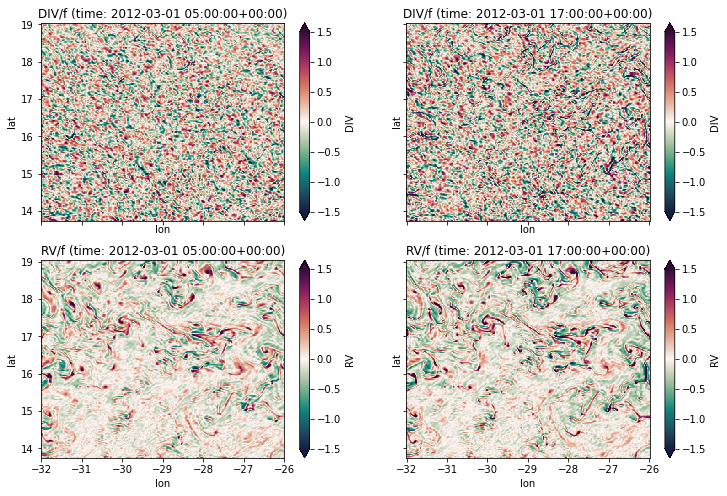

In [46]:
fig_kwargs={'x':'lon', 'y':'lat', 'cmap':'cmo.curl', 'norm':TwoSlopeNorm(vcenter=0.0), 'vmin':-1.5, 'vmax':1.5}

fig,ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8), sharex=True, sharey=True)
t_idx = 24*60+5

_ds1 = ds.isel(t=t_idx)
_t1 = ds_time[t_idx]
_ds1.DIV.plot.pcolormesh(ax=ax[0,0], **fig_kwargs)
ax[0,0].set_title('DIV/f (time: {})'.format(_t1))
_ds1.RV.plot.pcolormesh(ax=ax[1,0], **fig_kwargs)
ax[1,0].set_title('RV/f (time: {})'.format(_t1))

_ds2 = ds.isel(t=t_idx+12)
_t2 = ds_time[t_idx+12]
_ds2.DIV.plot.pcolormesh(ax=ax[0,1], **fig_kwargs)
ax[0,1].set_title('DIV/f (time: {})'.format(_t2))
_ds2.RV.plot.pcolormesh(ax=ax[1,1], **fig_kwargs)
ax[1,1].set_title('RV/f (time: {})'.format(_t2))
fig_rvdiv_map = plt.gcf()

plt.show()

In [ ]:
fig_rvdiv_map.savefig('figs/{}/RV-DIV_{}_am-pm_total.pdf'.format(rid, season))

In [47]:
gc.collect()
client.run(gc.collect)

{'tcp://127.0.0.1:36953': 600,
 'tcp://127.0.0.1:36971': 674,
 'tcp://127.0.0.1:44617': 598,
 'tcp://127.0.0.1:44765': 884}

#### Create filter

In [ ]:
filter_mask, kx, ky, om = create_filter_igw10(ds.U.shape, fmax=1.0/12.75, f_coriolis=f_cph, Nbv=Nbv_cph, H=H)
filter_r = filter_mask.compute()


2022-03-28 01:12:10 INFO     f_range -- Nt: 2184, T: 2184.0
2022-03-28 01:12:10 INFO     kxky -- Nx: 289, Ny: 288
2022-03-28 01:12:10 INFO     kxky -- Lx: 578.0, Ly: 576.0


N=0.928, H=4.911 - mode 10


#### Plot filter

In [ ]:
## Only for plot purposes
filter_plot = np.fft.ifftshift(filter_r)
filter_mask_ = filter_plot[144,145:,1104:].squeeze().T

om_r = om.compute()
kx_r = kx.compute()
ky_r = ky.compute()
kx_ = kx_r[144,145:,1104:].squeeze().T
ky_ = ky_r[144,145:,1104:].squeeze().T
om_ = om_r[144,145:,1104:].squeeze().T

print(1/np.min(kx_),1/np.max(kx_))
print(1/np.min(ky_),1/np.max(ky_))
print(1/np.min(om_),1/np.max(om_))
print(np.min(filter_mask_),np.max(filter_mask_))

578.0 4.013888888888888
1152.0 1152.0
4416.0 2.0009062075215223
2.411772939216257e-113 1.0


IndexError: tuple index out of range

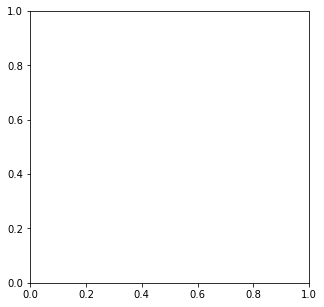

In [ ]:
## Display a "cut" of the filter
plt.figure(figsize=(5,5))
plt.pcolormesh(kx_,om_,filter_mask_, cmap=cm.gray)
plt.xscale('log')
plt.xticks(ticks=[1/200., 1/100., 1/50., 1/25., 1/10.], labels=[200, 100, 50, 25, 10], size='large')
plt.xlim([1/250.,1/8.])
plt.yscale('log')
plt.yticks(ticks=[1/7./24.,f_cph, 1/12.0, 1/6., 1/3.], labels=['7d', 'f', '12h', '6h', '3h'], size='large')
plt.ylim([1/(24.*7),1/2.])
plt.xlabel(r'Horizontal wavelength [km]',size='x-large')
plt.ylabel(r'Time scales',size='x-large')
cb = plt.colorbar()
cb.ax.tick_params(labelsize='x-large')
cb.set_label('Filter magnitude [adimentional]')
plt.savefig('figs/{}/wk_filter_2d.pdf'.format(rid))
plt.show()

In [ ]:
tidx_min,tidx_max = 1180,1280
print(1/np.abs(f_cph))
print(om_r.shape, 1/om_r[0,0,tidx_min],1/om_r[0,0,tidx_max])
print(np.min(filter_r), np.max(filter_r))

26.761540928923523
(288, 289, 2208) 28.862745098039216 12.509915014164307
2.411772939216257e-113 1.0


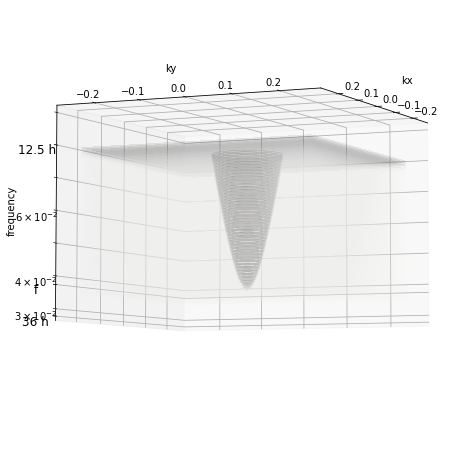

In [ ]:
import matplotlib as mpl

om_idx = [i for i in range(om_r.shape[2])]
nlevels=10
lvl = [i/nlevels for i in range(nlevels+1)]
#lvl = [0.4,0.5] 

min_ij=0
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, projection='3d')
for i in om_idx[tidx_min:tidx_max]:
    om_ = om_r[0,0,i]
    filter_slice = filter_plot[min_ij:,min_ij:,i].squeeze()
    #print(i,1/om_, np.min(filter_slice), np.max(filter_slice))
    cs = ax.contourf(kx_r[min_ij:,min_ij:,i].squeeze(), ky_r[min_ij:,min_ij:,i].squeeze(), filter_slice, zdir='z', offset=om_, levels=lvl, alpha=0.1, cmap=cm.gray, vcenter=0.1)
ax.set_zscale('log')
ax.set_zlim(1/30., 1/11.)
ax.set_zticks(ticks=[1/36., np.abs(f_cph), 1/12.5], labels=['36 h', 'f', '12.5 h'], size='large')
ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('frequency')
ax.view_init(elev=-5, azim=25)
#plt.savefig('figs/{}/wk_filter_3d.pdf'.format(rid))

plt.show()


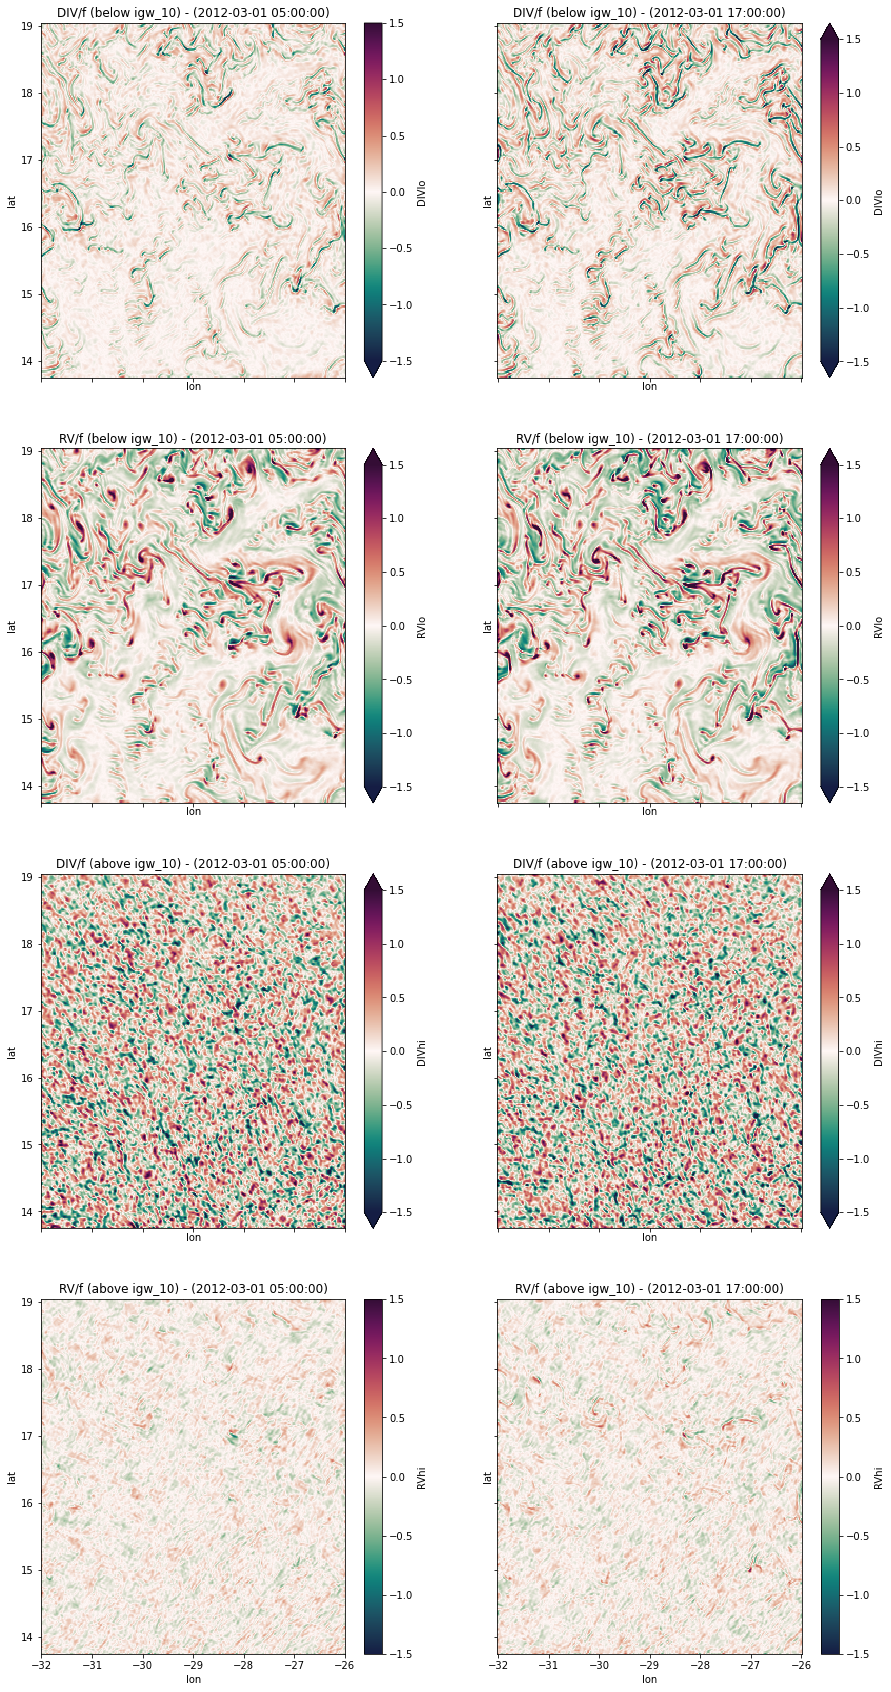

In [55]:
fig_kwargs={'x':'lon', 'y':'lat', 'cmap':'cmo.curl', 'norm':TwoSlopeNorm(vcenter=0.0), 'vmin':-1.5, 'vmax':1.5}

fig,ax = plt.subplots(nrows=4, ncols=2, figsize=(15,30), sharex=True, sharey=True)
t_idx = 24*60+5

_ds1 = ds.isel(t=t_idx)
_t1 = _tvec[t_idx]
_ds1.DIVlo.plot.pcolormesh(ax=ax[0,0], **fig_kwargs)
ax[0,0].set_title('DIV/f (below igw_10) - ({})'.format(_t1))
_ds1.RVlo.plot.pcolormesh(ax=ax[1,0], **fig_kwargs)
ax[1,0].set_title('RV/f (below igw_10) - ({})'.format(_t1))
_ds1.DIVhi.plot.pcolormesh(ax=ax[2,0], **fig_kwargs)
ax[2,0].set_title('DIV/f (above igw_10) - ({})'.format(_t1))
_ds1.RVhi.plot.pcolormesh(ax=ax[3,0], **fig_kwargs)
ax[3,0].set_title('RV/f (above igw_10) - ({})'.format(_t1))

_ds2 = ds.isel(t=t_idx+12)
_t2 = _tvec[t_idx+12]
_ds2.DIVlo.plot.pcolormesh(ax=ax[0,1], **fig_kwargs)
ax[0,1].set_title('DIV/f (below igw_10) - ({})'.format(_t2))
_ds2.RVlo.plot.pcolormesh(ax=ax[1,1], **fig_kwargs)
ax[1,1].set_title('RV/f (below igw_10) - ({})'.format(_t2))
_ds2.DIVhi.plot.pcolormesh(ax=ax[2,1], **fig_kwargs)
ax[2,1].set_title('DIV/f (above igw_10) - ({})'.format(_t2))
_ds2.RVhi.plot.pcolormesh(ax=ax[3,1], **fig_kwargs)
ax[3,1].set_title('RV/f (above igw_10) - ({})'.format(_t2))

fig_rvdiv_filtered_map = plt.gcf()

plt.show()

In [ ]:
fig_rvdiv_filtered_map.savefig('figs/{}/RV-DIV_{}_am-pm.pdf'.format(rid, season))
#MALLOC_TRIM_THRESHOLD_

### Plots: STDEV

In [ ]:
ts_fig_kwargs={'x':'time', 'y':'lat', 'cmap':'cmo.curl', 'norm':TwoSlopeNorm(vcenter=0.0), 'vmin':-1.5, 'vmax':1.5}
trange_7days = slice(24*40,24*48)

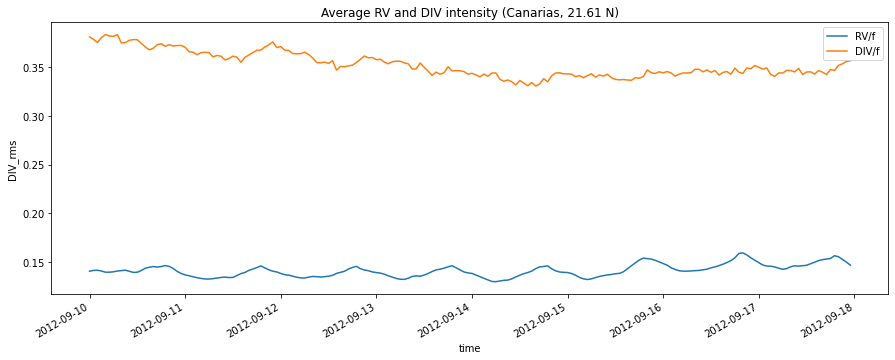

In [ ]:
plt.figure(figsize=(15,5))
ds.RV_rms.isel(t=trange_7days).plot(label="RV/f", x="time")
ds.DIV_rms.isel(t=trange_7days).plot(label="DIV/f", x="time")
plt.legend()
plt.title("Average RV and DIV intensity ({}, {:0.2f} N)".format(current,lat_deg))
fig_stv7d_total = plt.gcf()
plt.show()

In [ ]:
fig_stv7d_total.savefig('figs/{}/RV-DIV_{}_stdev_7days.png'.format(rid, season))

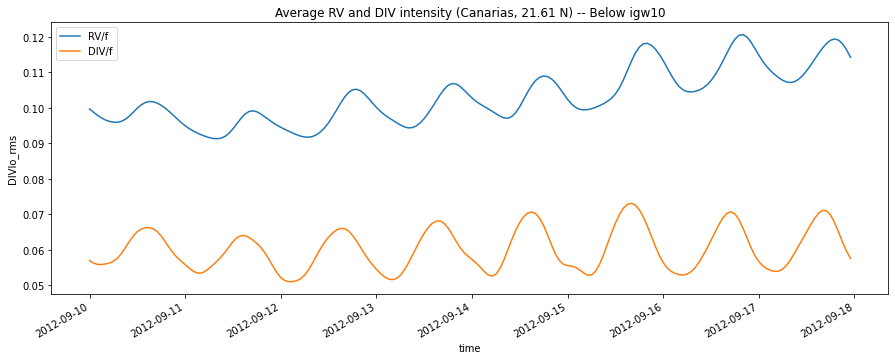

In [ ]:
plt.figure(figsize=(15,5))
ds.RVlo_rms.isel(t=trange_7days).plot(label="RV/f", x="time")
ds.DIVlo_rms.isel(t=trange_7days).plot(label="DIV/f", x="time")
plt.legend()
plt.title("Average RV and DIV intensity ({}, {:0.2f} N) -- Below igw10".format(current,lat_deg))
fig_stv7d_bm = plt.gcf()
plt.show()

In [ ]:
fig_stv7d_bm.savefig('figs/{}/RV-DIV_{}_stdev_bm_7days.png'.format(rid, season))

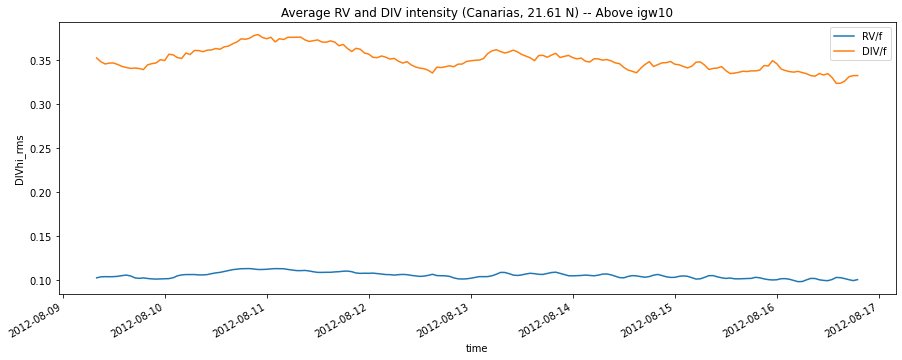

In [ ]:
plt.figure(figsize=(15,5))
ds.RVhi_rms.isel(t=slice(200,380)).plot(label="RV/f", x="time")
ds.DIVhi_rms.isel(t=slice(200,380)).plot(label="DIV/f", x="time")
plt.legend()
plt.title("Average RV and DIV intensity ({}, {:0.2f} N) -- Above igw10".format(current,lat_deg))
fig_stv7d_igw = plt.gcf()
plt.show()

In [ ]:
fig_stv7d_igw.savefig('figs/{}/RV-DIV_{}_stdev_igw_7days.png'.format(rid, season))

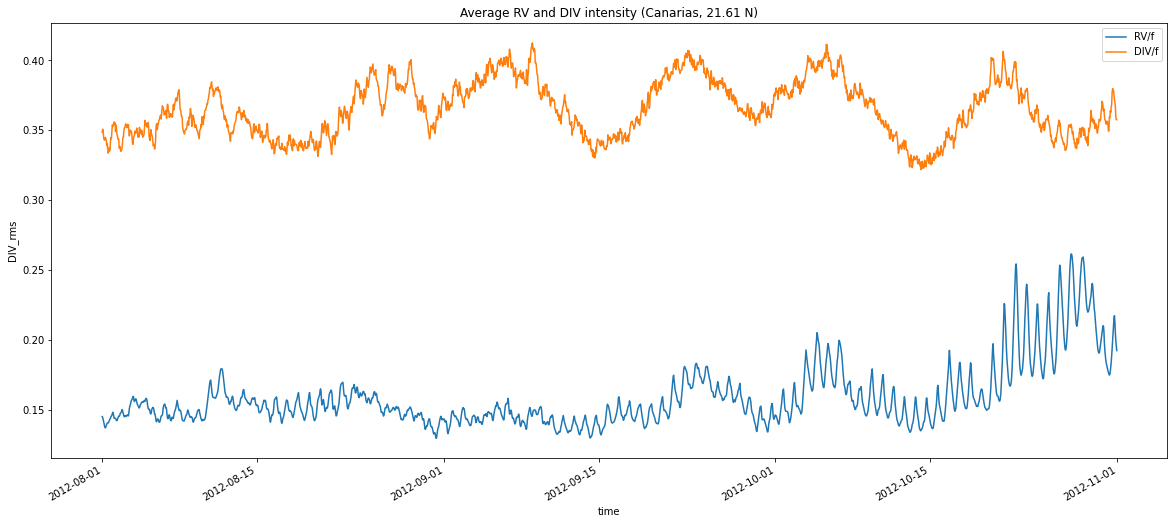

In [ ]:
plt.figure(figsize=(20,8))
ds.RV_rms.plot(label="RV/f", x="time")
ds.DIV_rms.plot(label="DIV/f", x="time")
plt.legend()
plt.title("Average RV and DIV intensity ({}, {:0.2f} N)".format(current, lat_deg))
fig_std_season = plt.gcf()
plt.show()

In [ ]:
fig_std_season.savefig('figs/{}/RV-DIV_{}_stdev.png'.format(rid,season))

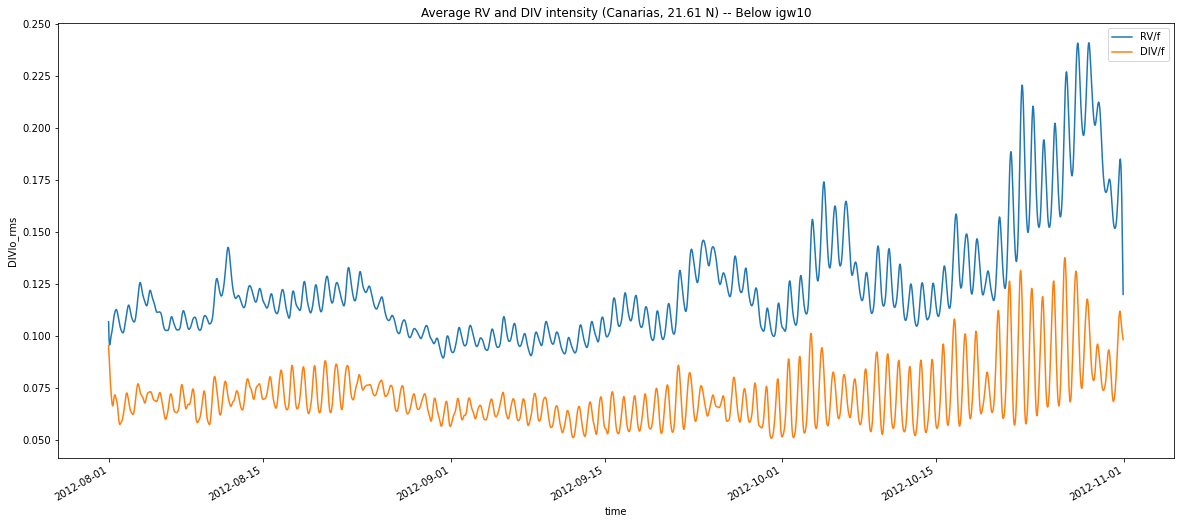

In [ ]:
plt.figure(figsize=(20,8))
ds.RVlo_rms.plot(label="RV/f", x="time")
ds.DIVlo_rms.plot(label="DIV/f", x="time")
plt.legend()
plt.title("Average RV and DIV intensity ({}, {:0.2f} N) -- Below igw10".format(current, lat_deg))
fig_std_bm_season = plt.gcf()
plt.show()

In [ ]:
fig_std_bm_season.savefig('figs/{}/RV-DIV_{}_stdev_bm.png'.format(rid,season))

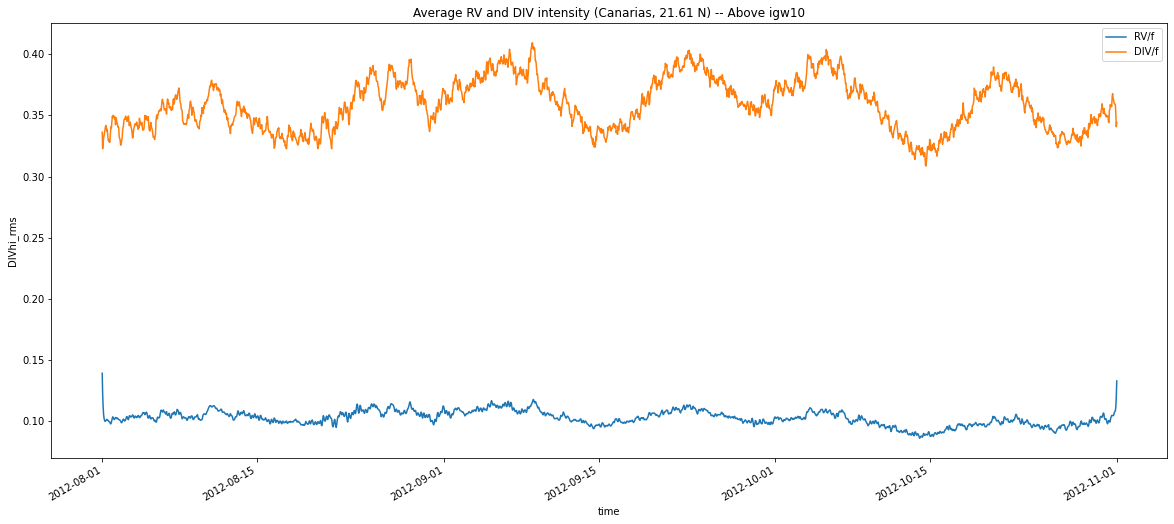

In [ ]:
plt.figure(figsize=(20,8))
ds.RVhi_rms.plot(label="RV/f", x="time")
ds.DIVhi_rms.plot(label="DIV/f", x="time")
plt.legend()
plt.title("Average RV and DIV intensity ({}, {:0.2f} N) -- Above igw10".format(current, lat_deg))
fig_std_igw_season = plt.gcf()
plt.show()

In [ ]:
fig_std_igw_season.savefig('figs/{}/RV-DIV_{}_stdev_igw.png'.format(rid,season))

## Figures: time series

In [38]:
def letter_range(start, stop="z", step=1):
    for ord_ in range(ord(start.lower()), ord(stop.lower())+1, step):
        yield chr(ord_)+")"

tick_fontsize = 20
tauRange = 0.0,0.23
mldRange = 0,260
thetaRange = 15,27
qnetRange = -600,400
rvdivRange = ((0.025,0.33),(0.025,0.5))
subplotLblPos = (0.02, 0.85)
subplotLblSize = 20
subplot_lbl_ah = [x for x in letter_range("a","h")]

In [11]:
def plot_ds(ds, ax, var_name, color, ylim, label, ylabel, xlim=(None,None)):
    ax.set_xlabel('')
    dsVar = ds[var_name]
    isTimeMean = "i" not in dsVar.dims
    dsVarStat = dsVar if isTimeMean else dsVar.mean(dim=("i","j"))
    plt.sca(ax)
    line, = dsVarStat.plot(x="time", c=color, label=label)
    ax.set(xlim=xlim, ylim=ylim)
    ax.tick_params(axis='y', colors=color, labelsize='xx-large')
    ax.set_aspect('auto')
    ax.set_xlabel('')
    return line

In [19]:
import seaborn as sns
import matplotlib.dates as mdates

plots = (
    ("Average wind intensity (|Tau|) and average KPPhbl (MLD)", ("tau_norm", "b", tauRange, "|Tau|", "|Tau| [Pa]"),("KPPhbl", "r", mldRange, "KPPhbl", "KPPhbl [m]")),
    ("Temperature (SST) and mean net heat flux (Qnet)", ("Theta", "b", thetaRange, "SST", "SST [$\degree$C]"),("oceQnet", "r", qnetRange, "oceQnet", "oceQnet [W/m^2]")),
    ("RMS normalized RV ($\zeta/f$) and DIV ($\delta/f$) - IGW regime", ("RVhi_rms", "xkcd:pinkish", rvdivRange[0], "$\zeta/f$", "$\zeta/f$"),("DIVhi_rms", "xkcd:olive green", rvdivRange[0], "$\delta/f$", "$\delta/f$")),
    ("RMS normalized RV ($\zeta/f$) and DIV ($\delta/f$) - BM regime", ("RVlo_rms", "xkcd:pinkish", rvdivRange[1], "$\zeta/f$", "$\zeta/f$"),("DIVlo_rms", "xkcd:olive green", rvdivRange[1], "$\delta/f$", "$\delta/f$")),
)

def plot_season_ts(current, region_id, forSeasons=["ASO","JFM"], t_idx_slice=slice(0,None), centerLine=None, cline_lw=5, useColorBar=False, save=True):
    # Vars 
    nRows=len(plots)
    nCols = len(forSeasons)
    maxColIdx = nCols-1
    
    with sns.axes_style("whitegrid"):
        ## HF - Plot
        fig, ax = plt.subplots(nRows,nCols,figsize=(10*nCols,3*nRows))
        figAxes = ax.flat[:]

        for col,season in enumerate(forSeasons):
            ds = xr.open_mfdataset("{}/datasets/{}_{}*.nc".format(DASK_DATA_FOLDER, region_id, season), chunks='auto')
            ds = ds.isel(t=t_idx_slice)
            _tvec = pd.to_datetime(ds.time.values, unit='ns')
            ds["time"] = (["t"], _tvec)
            
            ## X axis: time
            tMin = _tvec[0]
            tMax = _tvec[-1]
            days_in_plot = (tMax-tMin)/np.timedelta64(1,'D')
            print("time diff", days_in_plot, "days")
            if days_in_plot>30:
                fmt_major = mdates.MonthLocator(interval=1,bymonthday=1)
                fmt_minor = mdates.AutoDateLocator()
            else:
                fmt_major = mdates.AutoDateLocator()
                fmt_minor = mdates.DayLocator(interval=5)

            # Season time slice
            _tvec = pd.to_datetime(ds.time.values, unit='ns')
            #logging.info("{} ({}): {}, ({} to {})".format(rid,current,season))

            ## Loading Lt info and calculating sun angle
            #sunAngle_ = [sunAngle(lon,lat,t_) for t_ in time_hr]
            
            for row,plot in enumerate(plots):
                title,plot1,plot2 = plot
                figIdx = row*nCols+col
                ax1 = figAxes[figIdx]
                line1 = plot_ds(ds, ax1, *plot1)
                plt.text(subplotLblPos[0], subplotLblPos[1], subplot_lbl_ah[figIdx], fontsize=subplotLblSize, transform=ax1.transAxes)
                ax2 = ax1.twinx()
                line2 = plot_ds(ds, ax2, *plot2)
                
                #
                ax1.grid(b=False,axis='y')
                ax2.grid(b=False,axis='both') 
                plt.legend((line1,line2), (plot1[3], plot2[3]), loc="upper right", fontsize='x-large')
                ax1.set_ylabel('')
                ax2.set_ylabel('')
                plt.title(title, fontsize='xx-large')
                
                if row!=nRows-1:
                    plt.setp(ax1.get_xticklabels(), visible=False)
                if col==0:
                    ax1.set_ylabel(plot1[4], fontsize=tick_fontsize)
                else:
                    ax1.get_yaxis().set_ticklabels([])
                # Right ticks and labels
                if col==maxColIdx:
                    ax2.set_ylabel(plot2[4], fontsize=tick_fontsize)
                else:
                    ax2.get_yaxis().set_ticklabels([])

                ax1.xaxis.set_minor_locator(fmt_minor)
                ax1.xaxis.set_major_locator(fmt_major)
                
            #
            lastRowIdx = (nRows-1)*nCols+col
            lastRowAx = figAxes[lastRowIdx]
            lastRowAx.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
            lastRowAx.tick_params(axis='x', labelsize='xx-large')
            lastRowAx.set_xlabel("Time", size='xx-large')

        plt.scf(fig)
        if save:
            print("Saving figure...")
            ext = "pdf" if useColorBar else "eps"
            sliceTag = "" if centerLine is None else "_sliced"
            plt.savefig("figs/{}_{}{}_ts.{}".format(current, "-".join(forSeasons), sliceTag, ext), bbox_inches='tight')
            print("Saved!")
            
        print("Showing")
        fig.tight_layout()
        plt.show()


time diff 6.958333333333333 days
time diff 6.958333333333333 days
Saving figure...


2022-03-28 00:23:24 WARNING  The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Saved!
Showing


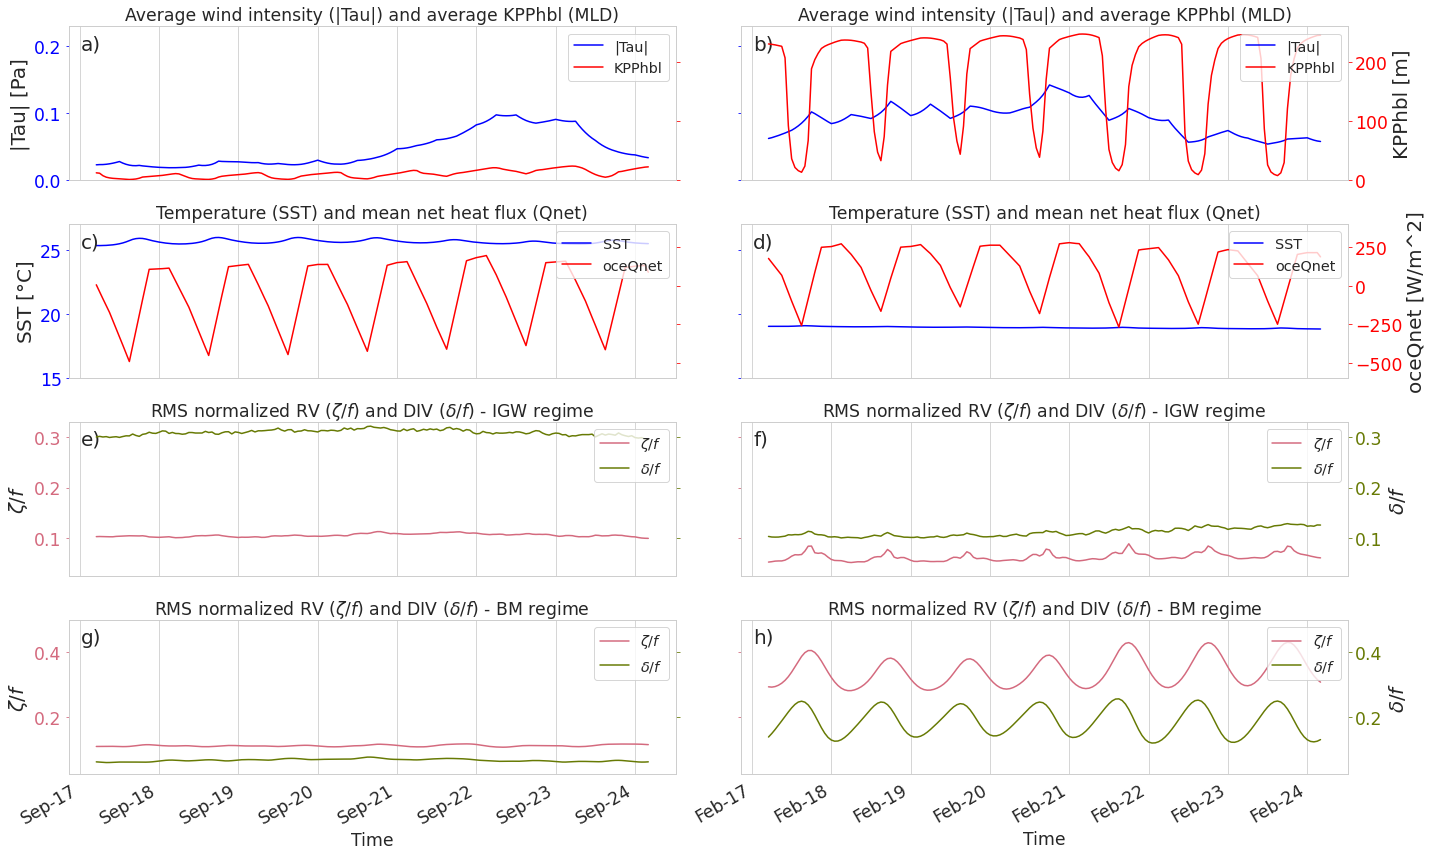

time diff 6.958333333333333 days
time diff 6.958333333333333 days
Saving figure...


2022-03-28 00:23:33 WARNING  The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Saved!
Showing


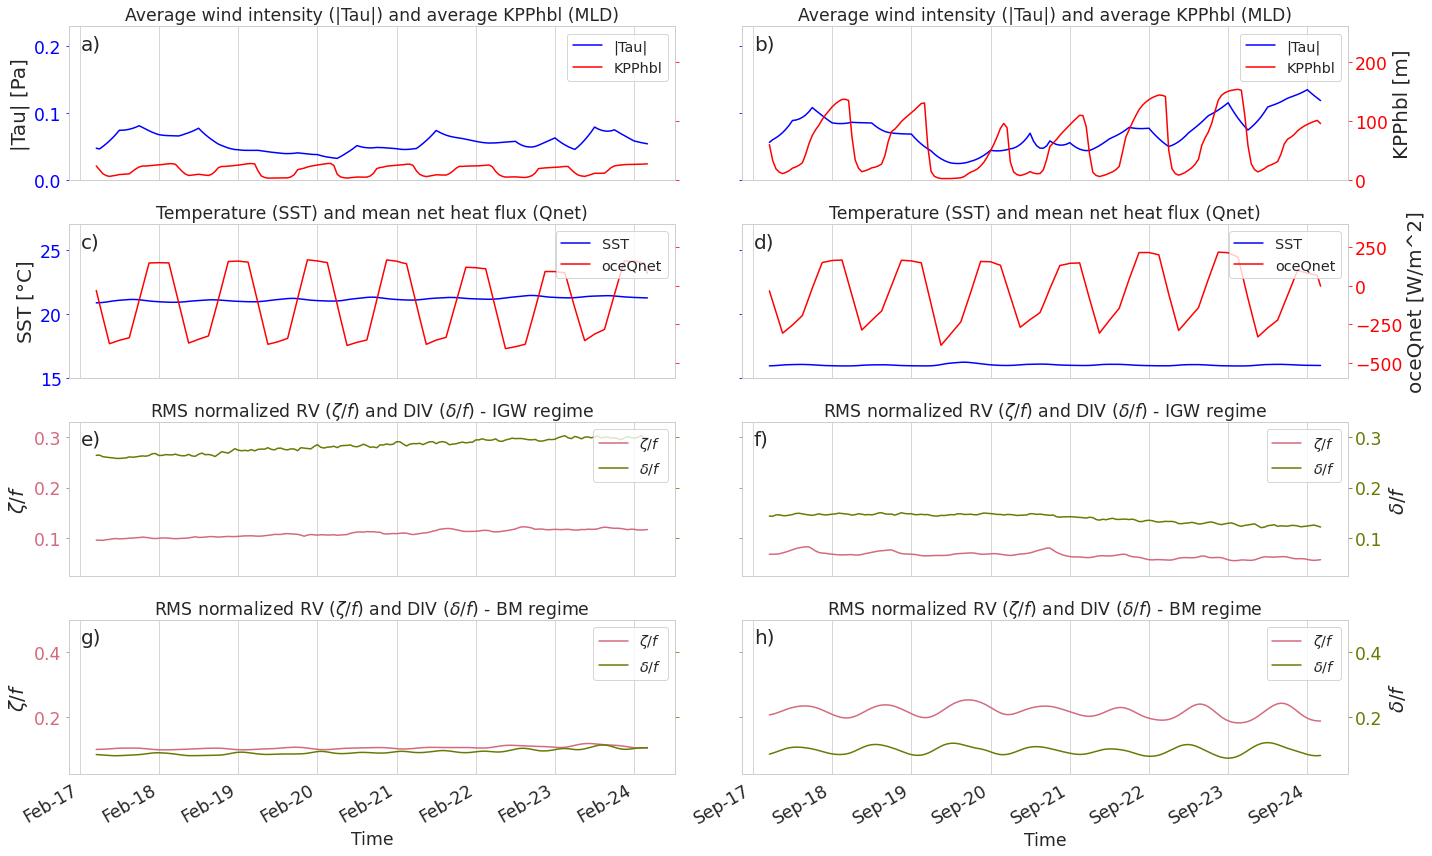

In [14]:
snapshot_t = 24*50+17
tzone = 0
zoom_ts_slice = slice(snapshot_t-7*12-tzone, snapshot_t+7*12-tzone)

plot_season_ts("Canary_sliced", 750, t_idx_slice=zoom_ts_slice, save=True)
plot_season_ts("Benguela_sliced", 533, t_idx_slice=zoom_ts_slice, forSeasons=["JFM","ASO"], save=True)


time diff 89.95833333333333 days
time diff 88.95833333333333 days
Saving figure...


2022-03-28 00:23:48 WARNING  The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Saved!
Showing


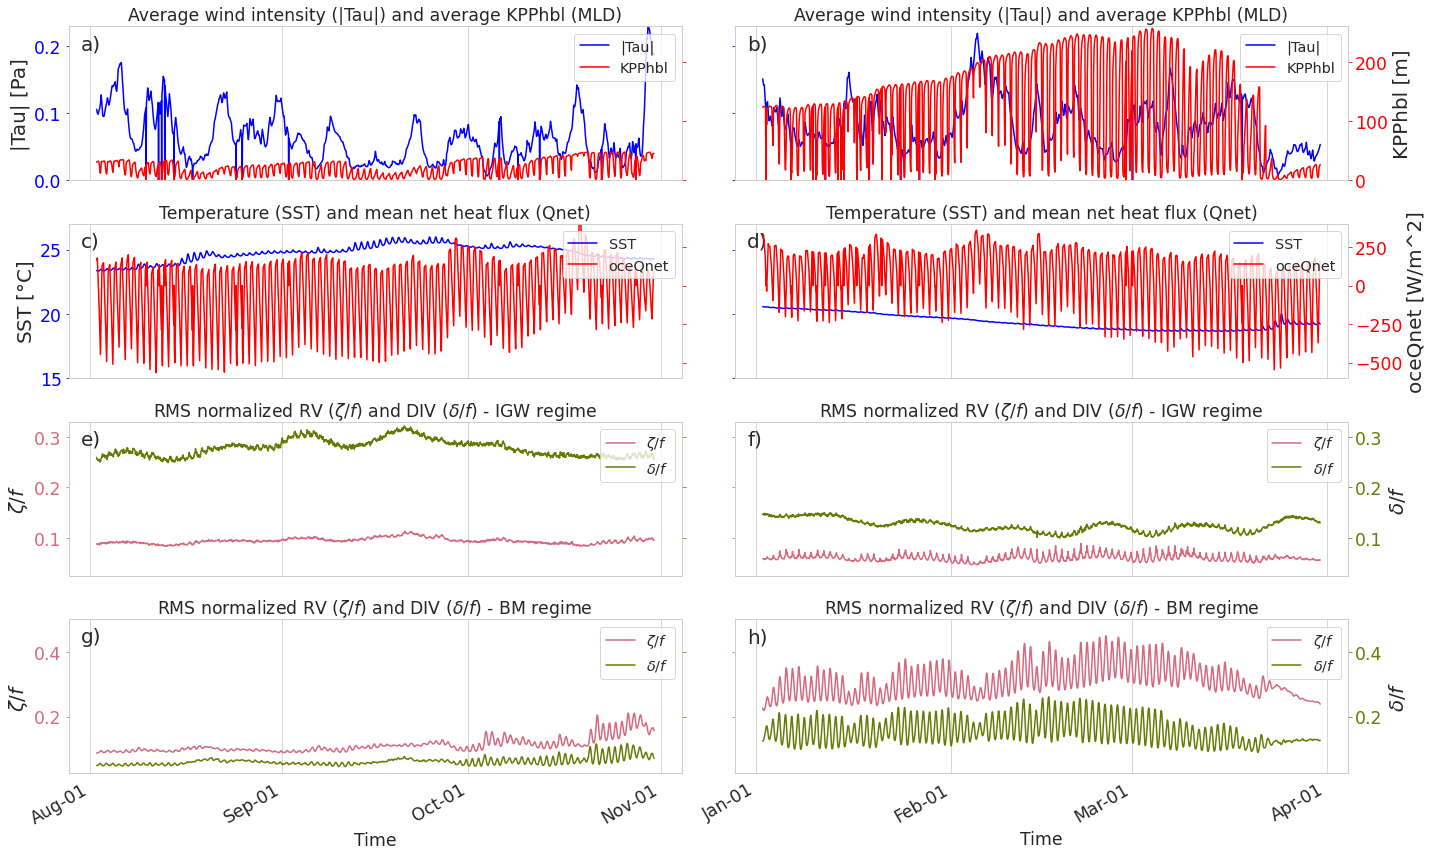

time diff 88.95833333333333 days
time diff 89.95833333333333 days
Saving figure...


2022-03-28 00:24:04 WARNING  The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Saved!
Showing


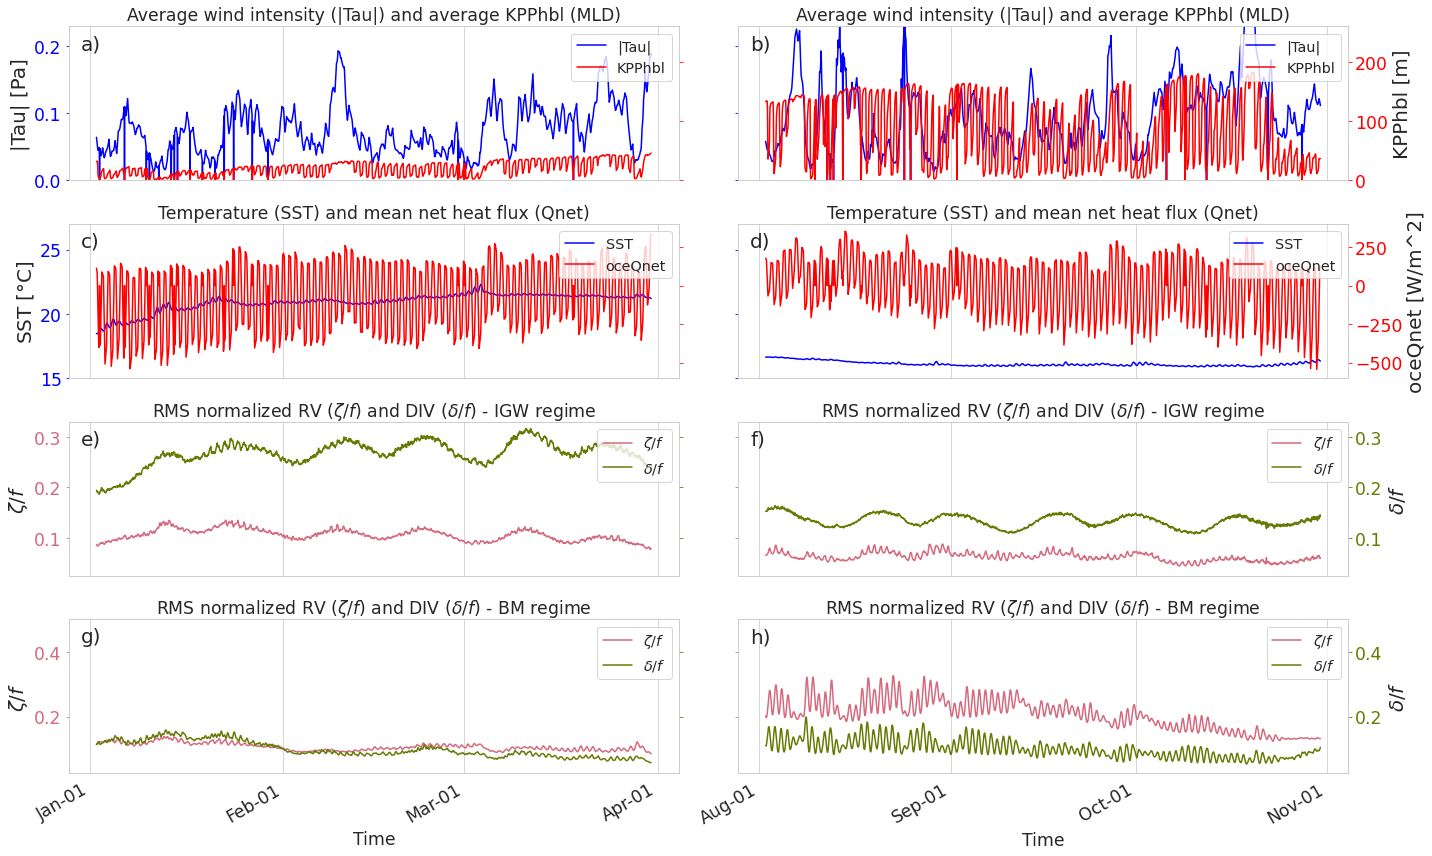

In [15]:
slice_seasons=slice(24,-24)
plot_season_ts("Canary", 750, t_idx_slice=slice_seasons, save=True)
plot_season_ts("Benguela", 533, t_idx_slice=slice_seasons, forSeasons=["JFM","ASO"], save=True)

In [35]:
from scipy import signal

days_window=10
nfft = days_window*24
f_ticklabels = [2,4,6,12,24,36,48,72,24*7,nfft]
#f_ticklabels = [6,12,24,36,48,72,24*4,24*7]
f_ticks = [1/tk for tk in f_ticklabels]

def plot_phasediff(current, region_id, forSeasons=["ASO","JFM"], t_idx_slice=slice(0,None), centerLine=None, cline_lw=5, useColorBar=False, save=True):
    # Vars 
    nRows=len(plots)
    nCols = len(forSeasons)
    maxColIdx = nCols-1
    
    with sns.axes_style("whitegrid"):
        for col,season in enumerate(forSeasons):
            ds = xr.open_mfdataset("{}/datasets/{}_{}*.nc".format(DASK_DATA_FOLDER, region_id, season), chunks='auto')
            ds = ds.isel(t=t_idx_slice)
            _tvec = pd.to_datetime(ds.time.values, unit='ns')
            ds["time"] = (["t"], _tvec)
            lenSample = len(_tvec)
            
            ##
            rv_bm = ds.RVlo_rms.data;
            div_bm = ds.DIVlo_rms.data;
            fig_, ax_ = plt.subplots(4,1,figsize=(10,20))

            #CSD
            plt.sca(ax_[0])
            fcsd, csd_zd = signal.csd(rv_bm, div_bm, fs=1., nperseg=nfft, detrend='linear', window='hamm')
            plt.stem(fcsd, np.abs(csd_zd))
            ax_[0].set_xscale('log')
            plt.xticks(ticks=f_ticks, labels=f_ticklabels)
            plt.ylabel("Cross spectral density")

            #Coherence
            plt.sca(ax_[1])
            fcoh, czd = signal.coherence(rv_bm, div_bm, fs=1., nperseg=nfft, detrend='linear', window='hamm')
            plt.stem(fcoh, czd)
            ax_[1].set_xscale('log')
            plt.xticks(ticks=f_ticks, labels=f_ticklabels)
            coh_zd = czd
            ci = 0.9
            edof = (lenSample/(nfft/2)) * coh_zd.mean()
            gamma = 1.-(1-ci)**(1./(edof-1.)) # Conf interval
            conf = np.where(coh_zd>gamma)
            plt.axhline(y=gamma, color='r', linestyle='-.')
            plt.ylabel("Coherence >{0}% interval ({1:.2f})".format(100*ci,gamma))

            #Phase (degrees)
            plt.sca(ax_[2])
            angle_zd = np.angle(csd_zd)*180/np.pi
            plt.plot(fcoh, angle_zd,'ro')
            #plt.plot(fcoh[conf], angle_zd[conf],'ro')
            ax_[2].set_xscale('log')
            plt.xticks(ticks=f_ticks, labels=f_ticklabels)
            plt.ylim([-185,185])
            ax_[2].set_yticklabels([-180,-135,-90,-45,0,45,90,135,180])
            plt.ylabel("Phase difference (degrees)")

            plt.sca(ax_[3])
            phdiff_hr = angle_zd/(fcoh*360.0)
            plt.plot(fcoh, phdiff_hr, 'ro')
            #plt.plot(fcoh[conf], phdiff_hr[conf], 'ro')
            ax_[3].set_xscale('log')
            plt.xticks(ticks=f_ticks, labels=f_ticklabels)
            plt.ylabel("Phase difference (hours)")
            plt.xlabel("Hours")
            plt.show()
            
            print("phase-diff", current, region_id, season)
            print("res:", 1/fcsd[10], np.abs(csd_zd)[10], czd[10], angle_zd[10], phdiff_hr[10])
            
            del ds
            gc.collect()
            client.run(gc.collect)


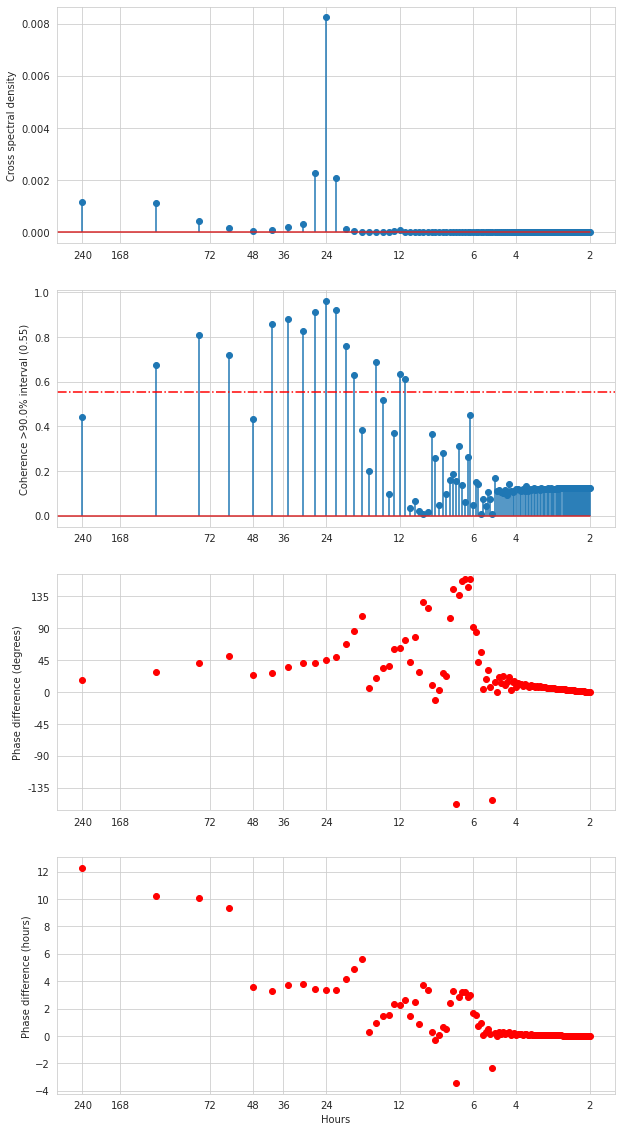

phase-diff Canary 750 ASO
res: 24.0 0.008242640216751008 0.9617922999373321 49.9631701996105 3.330878013307367


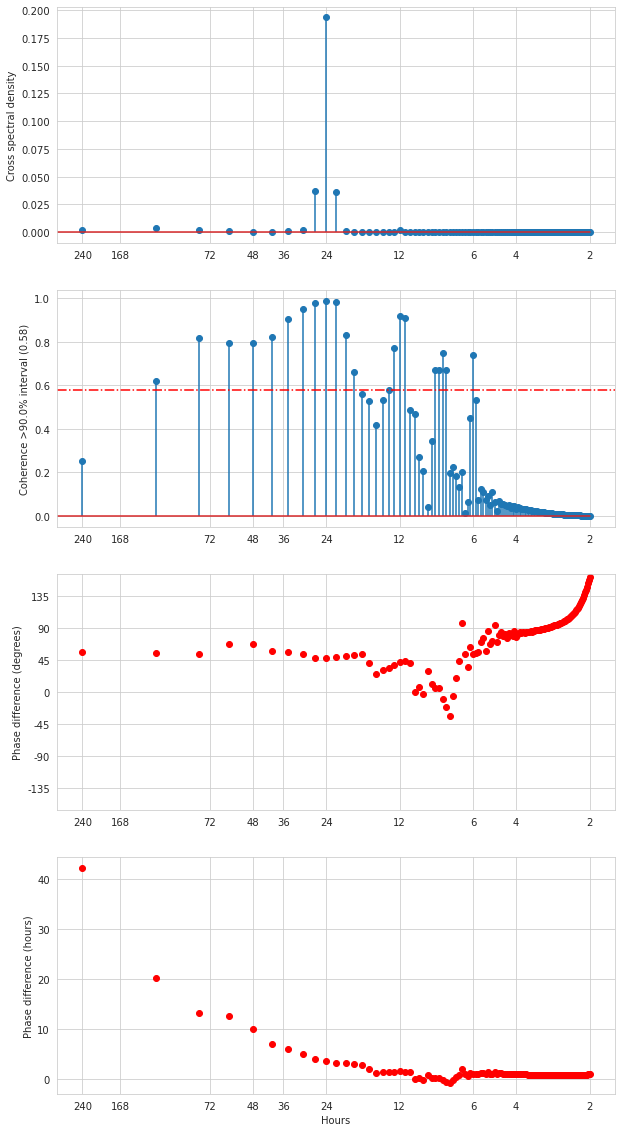

phase-diff Canary 750 JFM
res: 24.0 0.1936118500403412 0.9883094502131631 53.56460910375445 3.5709739402502967


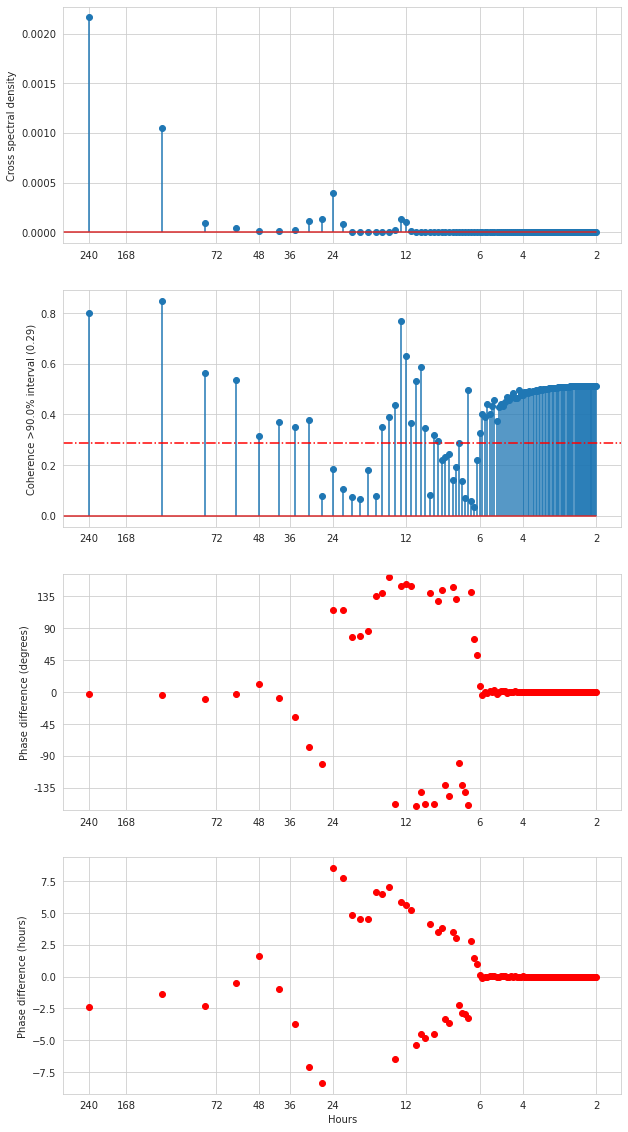

phase-diff Benguela 533 JFM
res: 24.0 0.00039895355035528875 0.1864343498676897 127.72480733796564 8.514987155864377


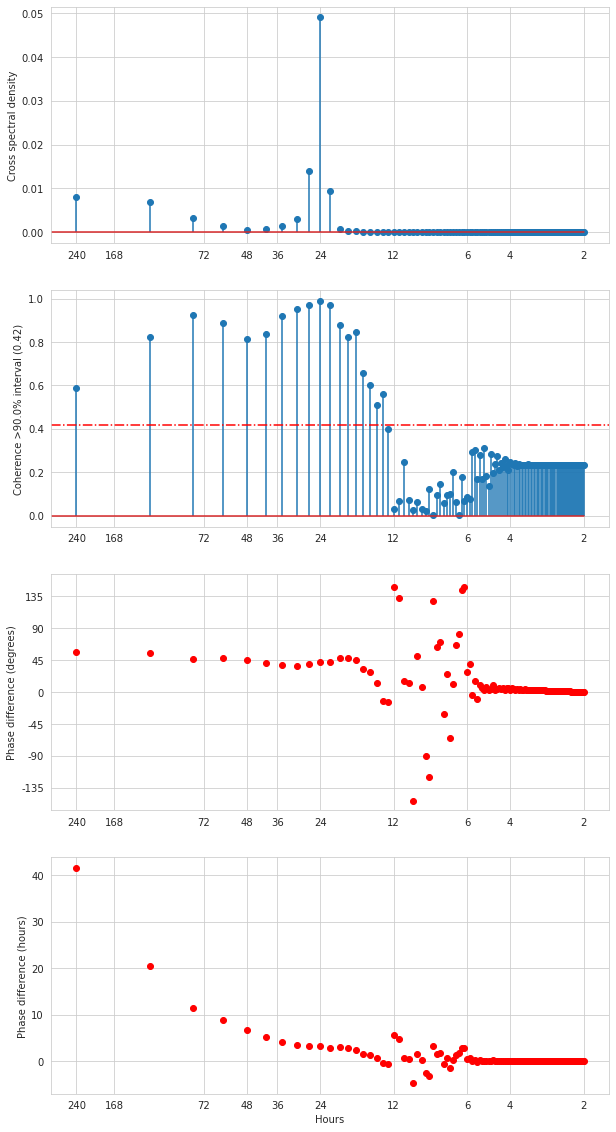

phase-diff Benguela 533 ASO
res: 24.0 0.049073620370239136 0.9887232331617111 46.99083944113126 3.1327226294087507


In [36]:
slice_seasons=slice(24,-24)

plot_phasediff("Canary", 750, t_idx_slice=slice_seasons, save=True)
plot_phasediff("Benguela", 533, t_idx_slice=slice_seasons, forSeasons=["JFM","ASO"], save=True)

In [40]:
import pickle
curr4id = {762:"California", 750:"Canary", 572:"Peru", 533:"Benguela"}

def plotjpdfs_sms():
    fig, ax = plt.subplots(4, 2, figsize=(5.5,9), sharex="all", sharey="all", constrained_layout=True)
    for i,region_id in enumerate([762,750,572,533]):
        seasons = ["ASO","JFM"] if i<2 else ["JFM","ASO"]
        for j,season in enumerate(seasons):
            ds = xr.open_mfdataset("{}/datasets/{}_{}*.nc".format(DASK_DATA_FOLDER, region_id, season), chunks='auto')
            ## Plot
            #
            plt.sca(ax[i,j])
            rv_bm = ds.RVlo.values
            div_bm = ds.DIVlo.values
            _,_,_,im_ = plt.hist2d(rv_bm.flat[:],div_bm.flat[:],bins=100,density=True,norm=LogNorm(clip=True),cmap=plt.cm.cubehelix_r)
            # incisos
            lbl_idx = i*2+j
            lbl = subplot_lbl_ah[lbl_idx]
            plt.text(-1.75, 1.75, lbl, fontsize=18)
            #plt.xlabel(r'$\dfrac{\zeta}{f}$',size='xx-large')
            plt.ylabel(curr4id[region_id],size='x-large')
            #plt.ylabel(r'$\dfrac{\delta}{|f|}$',size='xx-large',rotation='horizontal')

            plt.xlim([-2,3])
            plt.ylim([-2.5,2.5])
            plt.axvline(x=0,ls='--',c='k',alpha=0.5)
            plt.axhline(y=0,ls='--',c='k',alpha=0.5)
            ax[i,j].set_aspect('equal',adjustable="box", anchor="C", share=True)
            ax[i,j].tick_params(labelsize='medium')

            if i==0:
                if j==0:
                    plt.title("Summer",size='xx-large')
                elif j==1:
                    plt.title("Winter",size='xx-large')

    # Remove unnecessary labels
    for ax_ in ax.flat:
        ax_.label_outer()
        
    # Shared xy labels
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel(r'$\dfrac{\zeta}{f}$',size='xx-large')
    plt.ylabel(r'$\dfrac{\delta}{|f|}$',size='xx-large',rotation='horizontal')

    fig.tight_layout()
    cax = plt.axes([0.97, 0.3, 0.04, 0.5])
    cb = plt.colorbar(cax=cax)
    cb.ax.tick_params(labelsize='x-large')
    cb.set_label('Joint probability density function')
    #with open("{}/j_pdf/figure.pickle".format(LUIGI_OUT_FOLDER),"wb") as f_pkl:
    #    print("Dumping")
    #    pickle.dump(fig,f_pkl)
    print("Saving figure...")
    plt.savefig("figs/jpdf_4regs.pdf", bbox_inches='tight')
    print("Showing")
    plt.show()
    

In [ ]:
plotjpdfs_sms()